Este Notebook contém minhas anotações, e é baseado no original disponível em: https://www.kaggle.com/code/phelpsmemo/cap-351-neurocomputacao-projeto2-som

# Projeto 2 - Experimentos com Self-Organizing Maps (SOM)

**Descrição do projeto**: Realizar experimentos com pelo menos 3 datasets (Usar o Iris para debug). Variar a vizinhança e taxa de aprendizagem. Para cada teste realizado nos experimentos, os as seguintes representações dos mapas gerados devem ser geradas:

- U-Matrix
- Hit Map e Heat Maps

Além desses, para a avaliação, devem ser utilizados os erros `quantização` e `topográfico`.

**Bibliotecas base**

Para o desenvolvimento desta segunda atividade será feito o uso da biblioteca [MiniSom](https://github.com/JustGlowing/minisom). Outras bibliotecas também foram testadas, como o [Neupy](http://neupy.com/pages/home.html), [SOMPY](https://github.com/sevamoo/SOMPY) e [Somoclu](https://somoclu.readthedocs.io/en/stable/index.html), mas, optou-se pelo MiniSom por este ter o código fonte simples, o que foi utilizado em uma fase exploratória para o entendimento da maneira como a rede foi implementada.

> Para tornar possível os comentários sobre os comportamentos no Notebook e manter eles consistentes com outras execuções, uma seed foi definida e utilizada em todos os testes realizados.

In [1]:
RANDOM_STATE = 777

In [2]:
!pip install minisom > /dev/null
!pip install seaborn==0.11.0 > /dev/null

In [3]:
import numpy as np
import pandas as pd

import sklearn.datasets

from minisom import MiniSom

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from plotnine import *

np.random.seed(RANDOM_STATE) 

**Funções auxiliares**

Esta seção cria as funções auxiliares que serão consumidas no restante do código. 

> As funções auxiliares de visualização foram implementadas com base na [documentação do MiniSom](https://github.com/JustGlowing/minisom/tree/master/examples).


In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def umatrix(som_model, use_colorbar=True, transpose=False, **kwargs):
    """Plot Self-organizing Map U-Matrix
    
    Args:
        som_model (minisom.MiniSom): MiniSom Model
        
        use_colorbar (bool): Flag para ativar colorbar no plot
        
        kwargs (dict): Parâmetros para a função to matplotlib.pyplot.imshow
    Returns:
        matplotlib.figure.Figure: grid figure
    """   

    distance_map = som_model.distance_map()
    
    if transpose:
        distance_map = distance_map.T[::-1]

    im = plt.imshow(distance_map, **kwargs)
    if use_colorbar: plt.colorbar(im)


def umatrix_labeled(som_model, 
                    data, 
                    labels, 
                    colors, 
                    markers, 
                    use_colorbar=True,
                    plot_lbl_args=None,
                    **kwargs):
    """Plot U-Matrix com label em cada neurônio
    
    Args:
        som_model (minisom.MiniSom): MiniSom Model
        
        data (np.ndarray): n-dimensional array para estimular os neurônios
        e gerar o mapa de ativação
        
        labels (np.ndarray): 1-dimensional array com as labels. precisa ser valores 
        inteiros discretos (e. g. 0, 1, 2, ...)
        
        colors (list): Cores para cada uma das classes (Considera a posição com o label da classe)
        (e. g. classe 1 será a posição 1 desta lista)
        
        markers (list): Markers para cada uma das classes (Considera a posição)
        (e. g. classe 1 será a posição 1 desta lista)
        
        use_colorbar (bool): Flag para ativar colorbar no plot
        
        plot_lbl_args (dict): Parâmetros para a função matplotlib.pyplot.plot utilizada no plot
        das labels
        
        kwargs (dict): Parâmetros para a função to matplotlib.pyplot.imshow
    Returns:
        None
    """
    
    if not plot_lbl_args:
        plot_lbl_args = {
            'markerfacecolor': 'None',
            'markersize': 12,
            'markeredgewidth': 2
        }
    
    im = plt.imshow(som_model.distance_map(), **kwargs)
    if use_colorbar: plt.colorbar(im)
    
    for idx, de in enumerate(data):
        label_idx = labels[idx] - 1
        
        winner = som_model.winner(de)
        plt.plot(winner[1], winner[0], 
                 markers[label_idx], 
                 markeredgecolor=colors[label_idx],
                 **plot_lbl_args)


def hitmap(som_model, data, use_colorbar=True, transpose=False, **kwargs):
    """Plot Self-organizing map hitmap
    
    Args:
        som_model (minisom.MiniSom): MiniSom Model
        
        data (np.ndarray): n-dimensional array para estimular os neurônios
        e gerar o mapa de ativação
        
        use_colorbar (bool): Flag para ativar colorbar no plot
        
        transpose (bool): Transpoe e inverte a matriz
        
        kwargs (dict): Parâmetros para a função to matplotlib.pyplot.imshow
    Returns:
        None
    """     
    frequencies = som_model.activation_response(data).astype(int)
    
    if transpose:
        frequencies = frequencies.T[::-1]

    im = plt.imshow(frequencies, **kwargs)
    if use_colorbar: plt.colorbar(im)
    
    for (i, j), value in np.ndenumerate(frequencies):
        plt.text(j, i, value, verticalalignment='center', 
                              horizontalalignment='center')


def heatmap(som_model, feature_names, grid_spec, use_colorbar=True, **kwargs):
    """Plot Self-organizing map heatmap
    
    Args:
        som_model (minisom.MiniSom): MiniSom Model
        
        feature_names (list): Lista com o nome das labels
        
        grid_spec (tuple): Tupla com a quantidade de linhas e colunas do grid
        onde o heatmap será gerado
        
        use_colorbar (bool): Flag para ativar colorbar no plot
  
        kwargs (dict): Parâmetros para a função to matplotlib.pyplot.imshow
    Returns:
        None
    """

    weights = som_model.get_weights()
    
    for i, fname in enumerate(feature_names):
        plt.subplot(*grid_spec, i + 1)
        plt.title(fname)
        im = plt.imshow(weights[:, :, i], **kwargs)
        
        if use_colorbar: plt.colorbar(im)


def grid_pie_labeled(som_model, data, labels_name) -> tuple:
    """
    
    Args:
        som_model (minisom.MiniSom): MiniSom Model
        
        data (np.ndarray): n-dimensional data to estimulate neurons and generate
        activation map
        
        labels_name (np.ndarray): 1-dimensional array com o nome das classes. Precisa ser
        string (e. g. 'classe1', 'classe2', ...)
    
    Returns:
        tuple: Tupla com os patches e textos utilizados em cada neurônio
    """
    
    patches, texts = None, None
    labels_map = som_model.labels_map(data, labels_name)
    n_neurons, m_neurons = som_model.get_weights().shape[0:2]


    grid_spec = gridspec.GridSpec(n_neurons, m_neurons, plt.gcf())
    for position in labels_map.keys():
        label_fracs = [labels_map[position][l] for l in labels_name]
        plt.subplot(grid_spec[n_neurons-1-position[1],
                             position[0]], aspect=1)
        patches, texts = plt.pie(label_fracs)

    return (patches, texts)


def print_error(som_model, data) -> None:
    """Apresenta os erros de quantização e topográficos 
    de uma instância SOM treinada
    

    Args:
        som_model (minisom.MiniSom): Instância MiniSom treinada
        
        data (np.ndarray): array n-dimensional com os dados utilizados como entrada 
        nas funções de erro
    Returns:
        None
    """
    
    for method in ['quantization_error', 'topographic_error']:
        print(f'{method}: {getattr(som_model, method)(data)}')
        

def manual_random_training(som_model, data, max_iter) -> pd.DataFrame:
    """Função para treinamento da rede SOM com amostragem aleatória.
    
    Args:
        som_model (minisom.MiniSom): Instância MiniSom treinada

        data (np.ndarray): array n-dimensional com os dados utilizados no treinamento
        
        max_iter (int): Quantidade máxima de iterações
    
    Returns:
        pd.DataFrame: Tabela com os erros de quantização e topográficos gerados
    See:
        https://github.com/JustGlowing/minisom/blob/master/examples/BasicUsage.ipynb
    """
    
    errors = {
        'qerror': [],
        'terror': []
    }
    
    for idx in range(max_iter):
        data_random = data[np.random.randint(len(data))]
        
        som_model.update(data_random, som_model.winner(data_random), idx, max_iter)
        
        errors['qerror'].append(som_model.quantization_error(data))
        errors['terror'].append(som_model.topographic_error(data))
    return pd.DataFrame(errors)


## Experimento 1 - Iris *dataset*

Neste primeiro experimento será feita a utilização do conjunto de dados Iris, disponibilizado no [UCI Machine Learning](https://archive.ics.uci.edu/ml/datasets/iris). O conjunto de dados possui 150 amostras com 4 atributos (Comprimento e largura das sépalas e pétalas). Cada amostra pertence a uma classe de três classes possíveis, sendo elas as espécies de cada planta (Setosa, Virginica e Versicolor). A representação de cada atributo é feita na figura abaixo.

<div align="left">
    <img src="https://suspicious-wescoff-e06084.netlify.app/iris-datasetpng"/ width="650">
</div>


**Importação do conjunto de dados**

O conjunto de dados será carregado com o auxílio da biblioteca [scikit-learn](https://scikit-learn.org). 


In [5]:
iris = sklearn.datasets.load_iris()

Com os dados carregados, será feita a visualização da distribuição dos dados, isso ajuda a entender os grupos que estão sendo criados. A visualização é criada com a biblioteca [Seaborn](https://seaborn.pydata.org/).

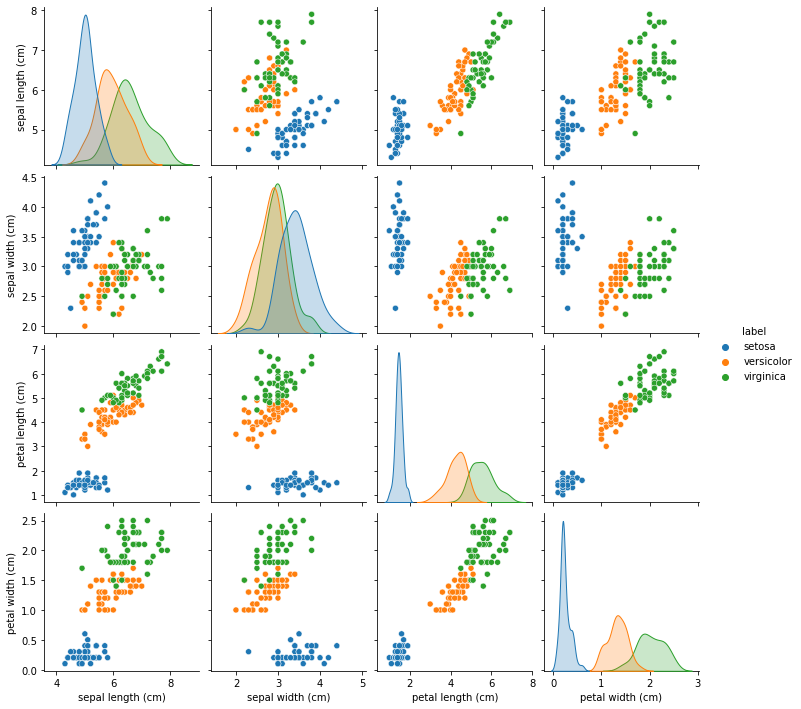

In [6]:
df = pd.DataFrame(iris.data, columns = iris.feature_names)
df['label'] = [iris.target_names[i] for i in iris.target]

sns.pairplot(df, hue = 'label')

### Teste 1 - Variação do grid

Para começar, o primeiro teste realiza a criação do grid em diferentes tamanhos, de modo a verificar o comportamento dos *micro-clusters* criados. Inicialmente será feita a variação em uma ordem crescente, começando em grid quadrados de `3x3`, `5x5` e `7x7`.

> Os demais parâmetros foram mantidos padrão, o que indica uma taxa de aprendizado de 0.5 e um sigma de 1.0. Além disso, os vizinhos dos neurônios são recuperados considerando um retângulo e o processo de cooperação é feito com uma distribuição gaussiana.

> Em consulta ao código fonte, foi verificado que o valor de `sigma` inserido é utilizado para o cálculo, em graus radianos, de um círculo de influência.

> Para a inicialização dos neurônios, neste teste é feita considerando uma função de seleção de amostras aleatórias, nomeada de `MiniSom.random_weights_init`.


**Funções auxiliares**

Abaixo, as funções auxiliares para este teste são definidas.


In [7]:
def test1_plot_multi_som_maps(som_model: 'minisom.MiniSom', data: 'sklearn.utils.Bunch', **kwargs) -> None:
    """Função para visualizar U-Matrix, hitmap e heatmap
    
    Args:
        som_model (minisom.MiniSom): Instância MiniSom
        
        data (sklearn.utils.Bunch): Bunch de dados carregados do sklearn
    Returns:
        None
    """ 
    
    def plot_heat_map_som(som_model, data, **kwargs):
        """Função para visualizar U-Matrix, hitmap e heatmap

        Args:
            som_model (minisom.MiniSom): Instância MiniSom

            data (sklearn.utils.Bunch): Bunch de dados carregados do sklearn
        Returns:
            None
        """      
        # get grid shape
        grid_shape = som_model.get_weights().shape[0:2]

        plt.figure(**kwargs)
        heatmap(som_model, data.feature_names, (2, 2), cmap='Reds')
        plt.suptitle('heatmap')
        
        plt.show()
    
    plt.figure(**kwargs)
    
    plt.subplot(2, 2, 1)
    umatrix(som_model, cmap='Reds')
    plt.title('U-Matrix')
    
    plt.subplot(2, 2, 2)
    hitmap(som_model, data.data, cmap='Reds')
    plt.title('hitmap')
    
    plt.show()
    plot_heat_map_som(som_model, data, **kwargs)

**Grid 3x3**

In [8]:
# 4 representa a quantidade de atributos
som3x3 = MiniSom(3, 3, 4, random_seed = RANDOM_STATE)

som3x3.random_weights_init(iris.data)
som3x3.train_random(iris.data, 1000)

print_error(som3x3, iris.data)

quantization_error: 0.5489861391502323
topographic_error: 0.04


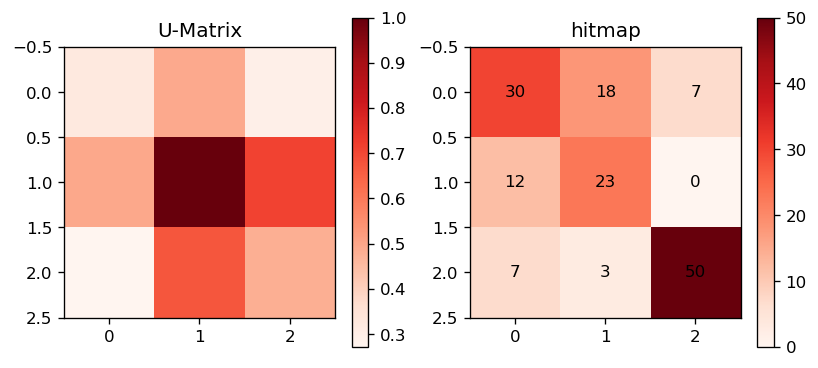

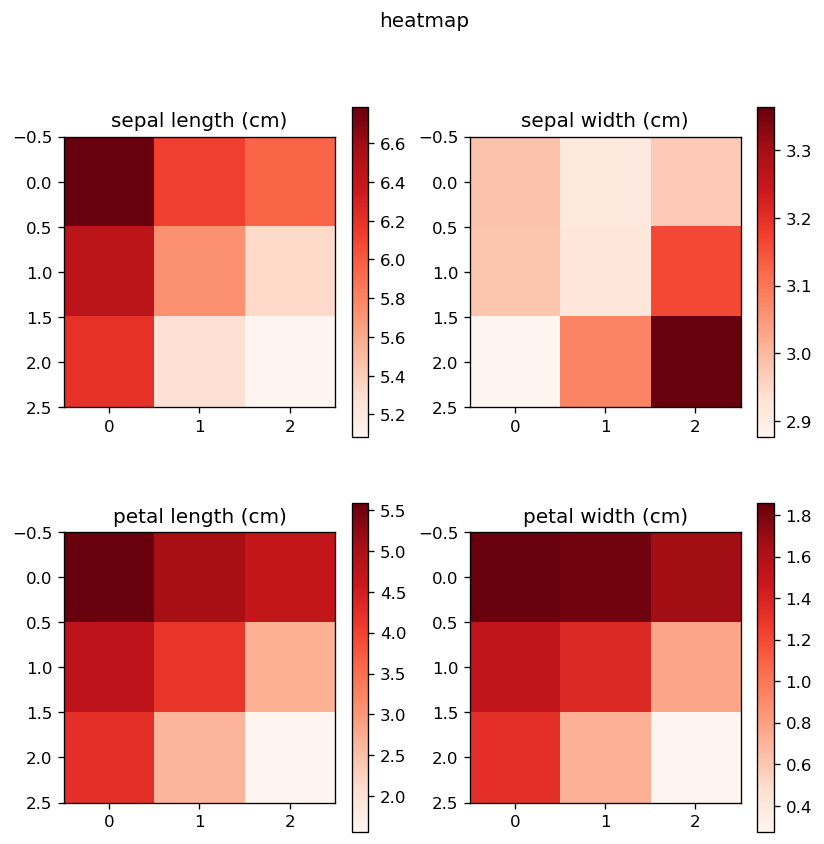

In [9]:
test1_plot_multi_som_maps(som3x3, iris, dpi=120, figsize=(8, 8))

**Grid 5x5**

In [10]:
som5x5 = MiniSom(5, 5, 4, random_seed = RANDOM_STATE)

som5x5.random_weights_init(iris.data)
som5x5.train_random(iris.data, 1000)

print_error(som5x5, iris.data)

quantization_error: 0.34599102489197037
topographic_error: 0.04


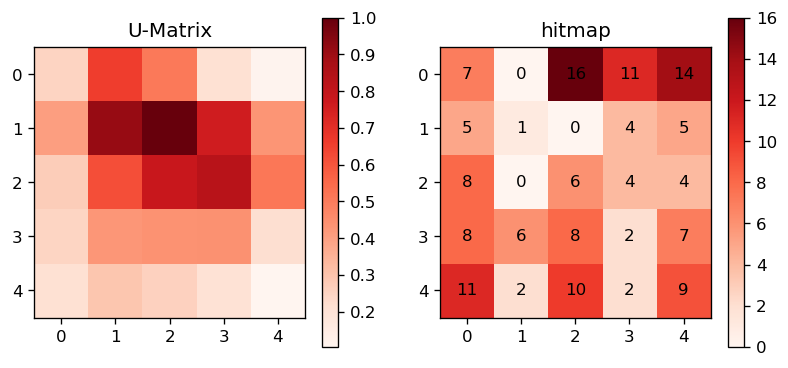

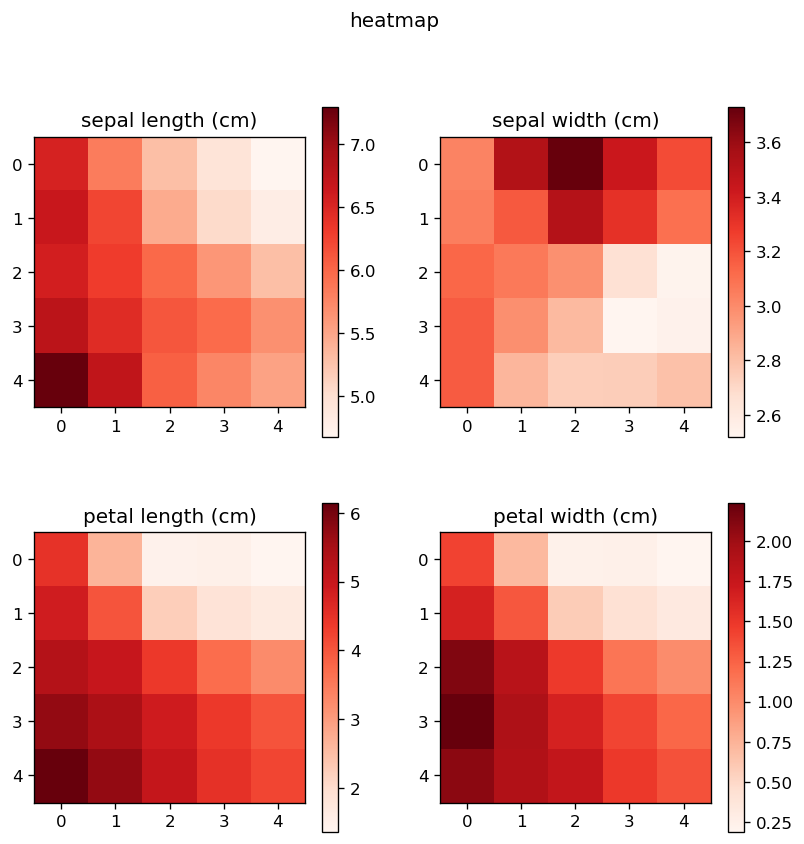

In [11]:
test1_plot_multi_som_maps(som5x5, iris, dpi=120, figsize=(8, 8))

**Grid 7x7**

In [12]:
som7x7 = MiniSom(7, 7, 4, random_seed = RANDOM_STATE)

som7x7.random_weights_init(iris.data)
som7x7.train_random(iris.data, 1000)

print_error(som7x7, iris.data)

quantization_error: 0.27373802736914704
topographic_error: 0.03333333333333333


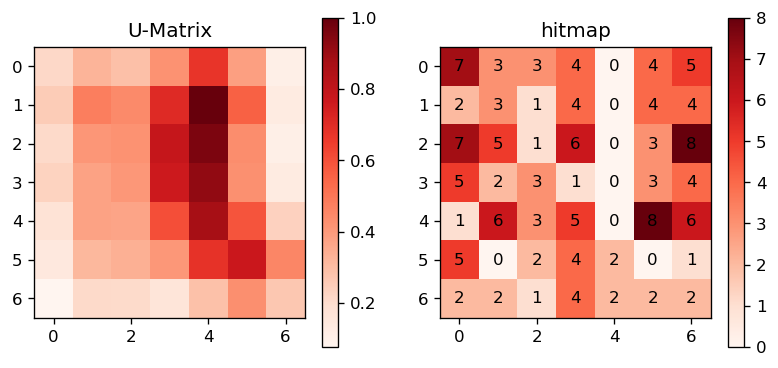

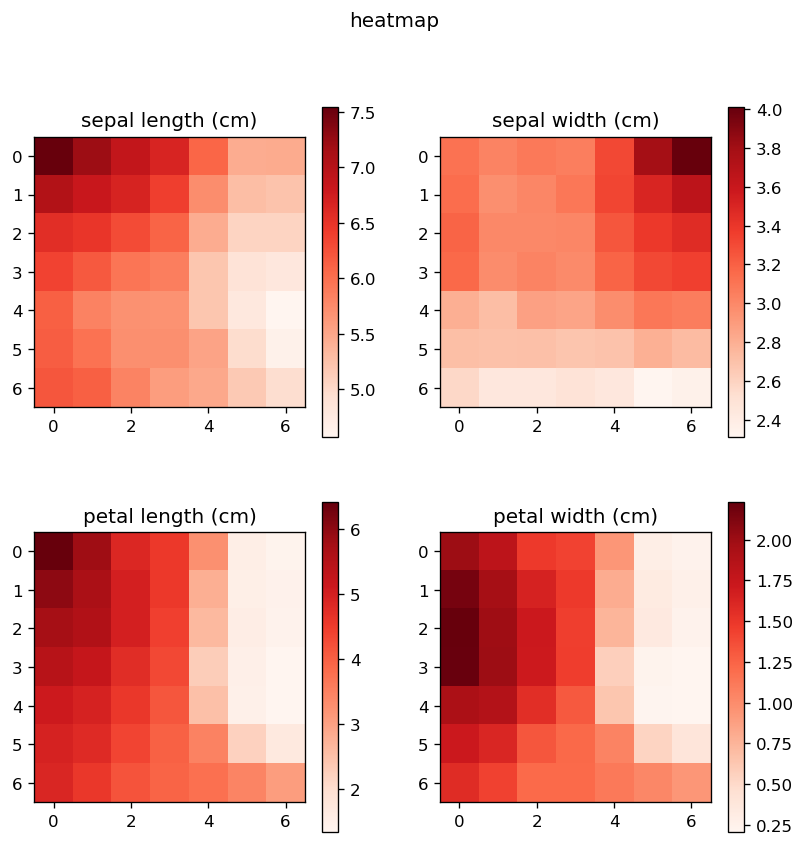

In [13]:
test1_plot_multi_som_maps(som7x7, iris, dpi=120, figsize=(8, 8))

Como o conjunto de dados selecionado para este teste contém os rótulos dos dados, essas informações serão utilizadas como forma de entendimento das representações que foram criadas e que estão expressas nas figuras acima.

> A visualização feita abaixo mostra a U-Matrix junto os rótulos dos elementos presentes em cada um dos neurônios.


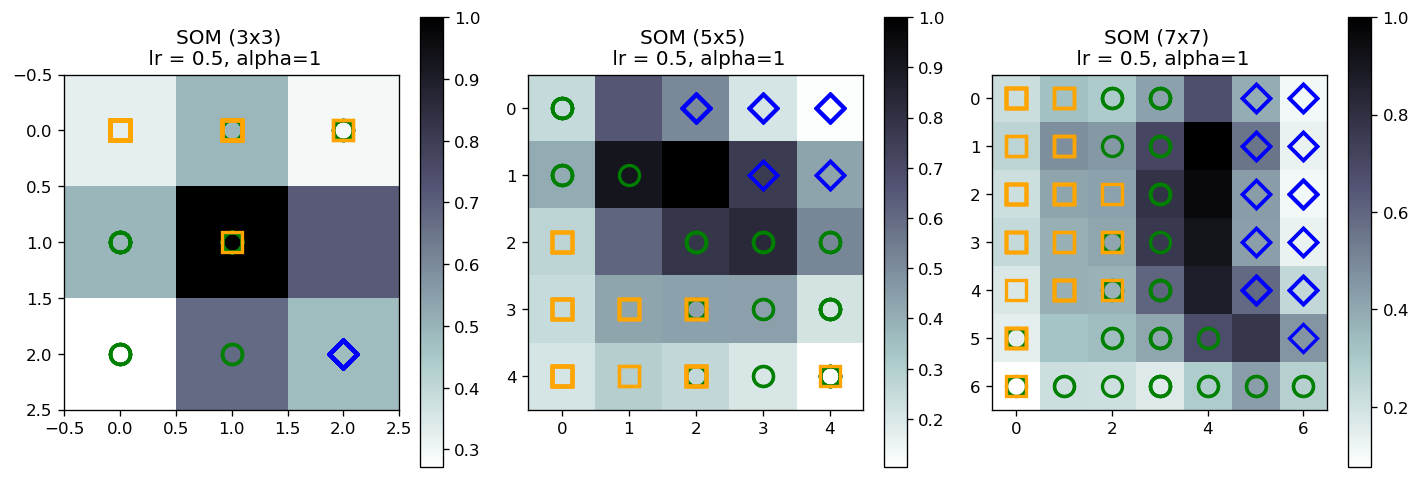

In [14]:
plt.figure(dpi = 120, figsize = (12, 12))

colors = ['green', 'orange', 'blue']
markers = ['o', 's', 'D']

plt.subplot(3, 3, 1)
umatrix_labeled(som3x3, iris.data, iris.target, colors, markers, cmap = 'bone_r')
plt.title('SOM (3x3) \n lr = 0.5, alpha=1')

plt.subplot(3, 3, 2)
umatrix_labeled(som5x5, iris.data, iris.target, colors, markers, cmap = 'bone_r')
plt.title('SOM (5x5) \n lr = 0.5, alpha=1')

plt.subplot(3, 3, 3)
umatrix_labeled(som7x7, iris.data, iris.target, colors, markers, cmap = 'bone_r')
plt.title('SOM (7x7) \n lr = 0.5, alpha=1')

plt.tight_layout()
plt.show()

Como pode ser observado na visualização criada com as distribuições entre cada uma das espécies, há uma certa confusão quando as características das espécies `Versicolor` e `Virginica`, sendo que a `Setosa`, em boa parte das comparçaões de distribuição, apresenta valores que as torna distante dos demais dados. Desta forma, ao inserir o conjunto de dados no SOM, era esperado um compartamento similar. Ao avaliar os resultados apresentandos, é possível perceber que tal comportamento é mantido em todos os mapas gerados.

Ao considerar os resultados gerados no grid `3x3`, é possível notar que a classe `Setosa` (apresentada em azul), não se misturou com as demais, assim como é esperado. Além disso, ao considerar as informações que podem ser extraídas do HeatMap e compará-las com as distribuições apresentadas, é notável as semelhanças nas características da representação criada com a distribuição da classe. 

Nos neurônios apresentados no grid `5x5` e `7x7`, nota-se a problemática entre as classes `Versicolor` e `Virginica`, mesmo com a especialização de neurônios para esses elementos. É tido também que, nestes grids, houve a especialização maior as características da classe `Setosa`, e mesmo desta forma, não houve nenhum tipo de mistura com as demais classes.

Para todos os casos estiveram presentes neurônios "mortos", que não fizeram a representação de nenhuma amostra, o que aumentou com o crescimento do grid. 

Por fim, para os erros, tem-se que, o baixo valor do erro topográfico mostra que o ajuste das representações realizadas gerou neurônios próximos que tendem a fazer as mesmas representações. Para as quantizações, é possível dizer que a especialização dos neurônios, fez com que os erros causados por neurônios vencedores com distância considerável pode ser resolvido, diminuindo assim o erro geral apresentado.

### Teste 2 - Visualizando elementos nos neurônios

Para todos os grids gerados no Teste 1, teve-se a confusão entre as classes `Versicolor` e `Virginica`. Para entender melhor o motivo e verificar as características de cada neurônio que possui erros, será feita a extração dos valores desses e então sua visualização.

A realização deste teste será feita com o grid de neurônios com dimensão 7x7, por este ter apresentado os resultados mais ricos e interessantes em relação a representação de características de todas as classes presentes no conjunto de dados.

**Função auxiliar**

In [15]:
def extract_index_of_equal_array(data, arrays):
    """Extrai índices de arrays iguais de uma estrutura multidimensional. Compara
    todas as dimensões de dois arrays e determina se são iguais, caso seja, o índica
    do primeiro elemento (data) é salvo.
    
    Args:
        data (np.ndarray): array n-dimensional com os valores onde a busca será feita
        
        arrays (np.ndarray): array n-dimensional com os valores a serem buscados
        
    Returns:
        np.ndarray: Array 1-dimensional com os índices dos valores selecionados
    """
    index = []
    for idx, arr in enumerate(data):
        for arr2 in arrays:
            if np.array_equal(arr, arr2):
                index.append(idx)
    return np.array(index)

Para iniciar, é feita a definição dos neurônios identificados com problemas de confusão entre as classes no mapa 7x7 apresentados no teste anterior.

> Ao consultar a estrutura interna do MiniSom, notou-se que toda a manipulação é feita somente com Numpy, o que da margem para fazer buscas considerando a posição da matriz, o que torna o teste mais simples e claro de ser realizado e interpretado, já que, as mesmas posições apresentadas na figura do grid 7x7 serão as definidas para extração.


In [16]:
confuse_neuron_on_7x7_grid = [
    (5, 0), (6, 0), (3, 2), (4, 2)
]

Agora faz-se a geração da localização para onde cada elemento do conjunto de dados foi armazenado no mapa. Este processo é feito com o auxílio do método `MiniSom.win_map`.

In [17]:
winner_map = som7x7.win_map(iris.data)

winner_data = []
for i in [winner_map[confuse_idx] for confuse_idx in confuse_neuron_on_7x7_grid]:
    winner_data.extend(i)
winner_data = np.array(winner_data)

Feito isto, a extração das amostras que estavam presentes na confusão podem ser extraídas

In [18]:
index = extract_index_of_equal_array(iris.data, winner_data)

iris_data_confuse = iris.data[index]
iris_data_confuse_target = iris.target_names[iris.target[index]]

Extraíndo os pesos

In [19]:
winner_confuse_neurons = np.array([som7x7.get_weights()[i] for i in confuse_neuron_on_7x7_grid])

Para fechar, o preparação e visualização dos dados são realizados.

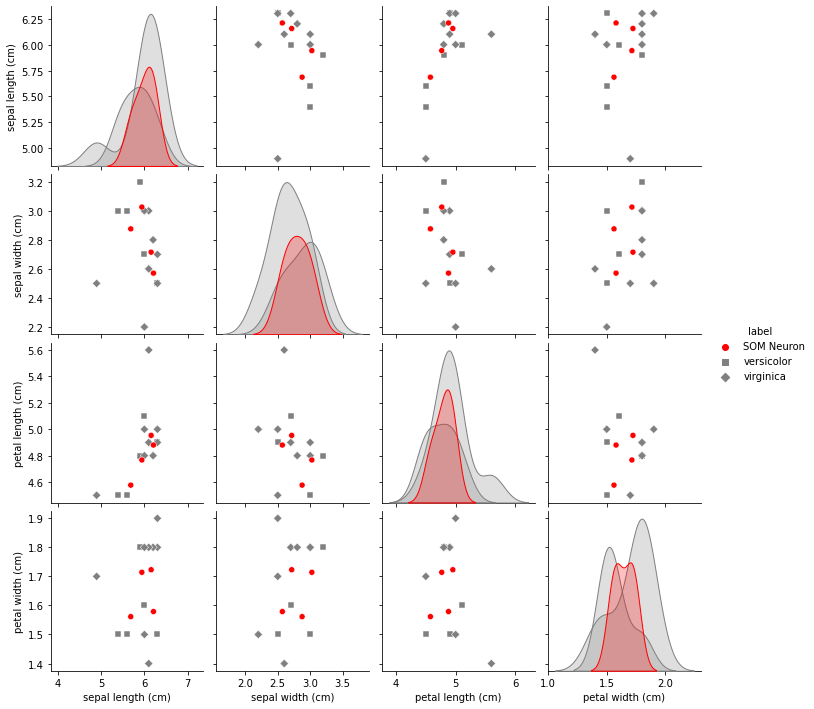

In [20]:
_target = np.concatenate([iris_data_confuse_target, np.repeat('SOM Neuron', winner_confuse_neurons.shape[0])]).ravel()
_data = np.concatenate([iris_data_confuse, winner_confuse_neurons])

df2 = pd.DataFrame(_data, columns = iris.feature_names)
df2['label'] = pd.Categorical(_target)

sns.pairplot(df2, hue = 'label', palette = {
    'versicolor': 'gray',
    'virginica': 'gray',
    'SOM Neuron': 'red'
}, markers=["o", "s", "D"])

Ao visualizar o resultado acima, é possível perceber que somente estão presentes na confusão as classes `Versicolor` e `Verginica`, como esperado. Além disso, é possível notar que de maneira geral, os neurônios acabaram abrangindo as características de ambas as classes, uma vez que, como analisado, eles responderam a ambos os padrões de entrada.

### Teste 3 - Taxa de aprendizado

Como forma de compreender o impacto causado pela taxa de aprendizado durante o treinamento, neste teste serão considerados diferentes valores como taxas de aprendizado para verificar o comportamento da rede. O processo será controlado pela avaliação dos erros de quantização e topográficos.

> Em verificação no código fonte do MiniSom, foi identificado que em seu processo de aprendizado, as atualizações acontecem para cada padrão de amostra apresentado. Outras implementações como SOMPY apresentam outras formas de realizar este processo. Para o contexto deste teste, esta característica será utilizada de forma que, para cada amostra inserida, um valor de erro de quantização e topográfico seja gerado. Este processo é apresentado em um dos exemplos disponibilizados na [documentação do MiniSom](https://github.com/JustGlowing/minisom/blob/master/examples/BasicUsage.ipynb). Neste documento, esse processo foi materializado na função auxiliar `manual_random_training`. 

> Na função `manual_random_training`, a apresentação das amostras durante o treinamento é feita de maneira aleatória.

Nestes testes, será considerado as mesmas configurações da rede com grid 7x7 utilizada nos últimos dois testes.

**Funções auxiliares**

In [21]:
def test3_som_factory_with_different_learning_rate(learning_rates: list, data: np.ndarray) -> tuple:
    """Função para gerar múltiplos SOM variando a taxa de aprendizado
    
    Args:
        larning_rates (list): Lista com diversas taxas de aprendizado
        
        data (np.ndarray): array n-dimensional com os dados utilizados no treinamento
        
    Returns:
        tuple: Tuple contendo tabela com os valores de erros de quantização e topográficos para cada
        taxa de aprendizado inserida e os modelos ajustados    
    """
    
    models = {}
    results = []
    for lr in learning_rates:
        _som = MiniSom(7, 7, 4, learning_rate=lr, random_seed = RANDOM_STATE)
        
        # Mesma quantidade de iterações utilizada no teste "original" 
        # da rede com grid 7x7 (Experimento 1 - Teste 1)
        _lr_error = manual_random_training(_som, data, 1000)
        
        _lr_error['label'] = lr
        _lr_error['label'] = pd.Categorical(_lr_error['label']).astype(str)
        
        models[lr] = _som
        
        results.append(_lr_error)
    return pd.concat(results), models


Para o teste, serão testados valores que vão de escala muito pequenas até escalar maiores. O processo de geração dos erros para cada taxa de aprendizado testada é apresentado abaixo.

In [22]:
df_learning_rate, models_test3 = test3_som_factory_with_different_learning_rate([0.005, 0.05, 0.5, 0.7, 0.9, 1.2], iris.data)

**Erro de quantização**

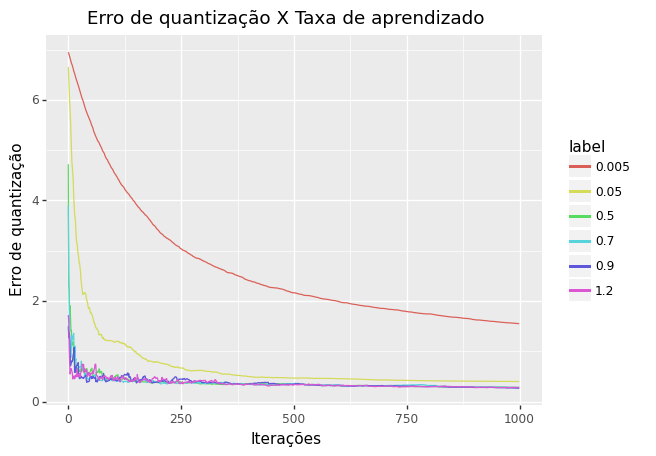

<ggplot: (8772237503057)>

In [23]:
(
    ggplot(df_learning_rate, aes(x = 'df_learning_rate.index', y = 'qerror', color = 'label'))
        + geom_line()
        + xlab("Iterações") 
        + ylab("Erro de quantização")
        + ggtitle("Erro de quantização X Taxa de aprendizado")
)

**Erro de topografia**

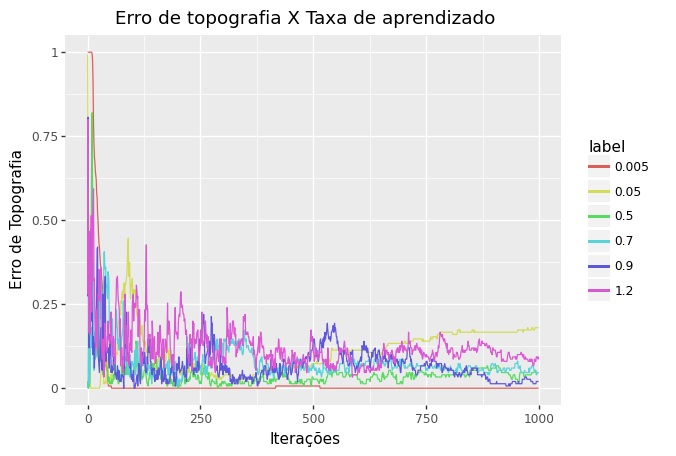

<ggplot: (8772237451973)>

In [24]:
(
    ggplot(df_learning_rate, aes(x = 'df_learning_rate.index', y = 'terror', color = 'label'))
        + geom_line()
        + xlab("Iterações")
        + ylab("Erro de Topografia")
        + ggtitle("Erro de topografia X Taxa de aprendizado")
)

Ao analisar os resultados, tem-se comportamentos já esperados. Para as taxas de aprendizado muito baixas, os erros de quantização demoram a reduzir, como acontece com o valor `0.005`.

> Cabe lembrar que este erro foi gerado após a apresentação de cada amostra para a rede (Os pesos da rede são atualizados para cada amostra apresentada, como já citado anteriormente).

De maneira geral, os testes com taxas de aprendizado $[0.05, 0.5, 0.7, 0.9]$ apresentaram comportamento semelhante em ambos os erros, sendo necessário uma avaliação modelo a modelo para certificação da maneira a qual as representações foram criadas em cada uma das redes treinadas.


**Visualização dos mapas gerados com diferentes taxas de aprendizado**

Para entender os padrões de comportamento apresentados nas figuras acima, será feito a visualização dos mapas para os testes com taxa de aprendizado igual a `0.005` e `1.2`. Esses foram selecionados por representar elementos que representarem comportamentos opostos, onde um tem uma variação muito rápida e outro uma variação muito curta.

In [25]:
# extração dos modelos com as taxas de aprendizado indicadas
som_lr0005 = models_test3[0.005]
som_lr12 = models_test3[1.2]

Visualização dos resultados

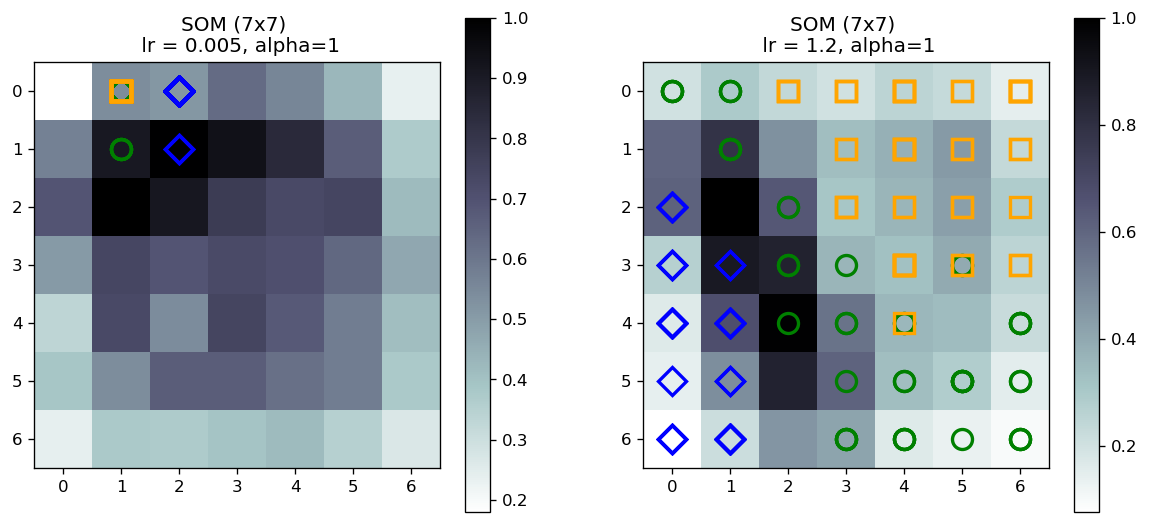

In [26]:
plt.figure(dpi = 120, figsize = (12, 12))

colors = ['green', 'orange', 'blue']
markers = ['o', 's', 'D']

plt.subplot(2, 2, 1)
umatrix_labeled(som_lr0005, iris.data, iris.target, colors, markers, cmap = 'bone_r')
plt.title('SOM (7x7) \n lr = 0.005, alpha=1')

plt.subplot(2, 2, 2)
umatrix_labeled(som_lr12, iris.data, iris.target, colors, markers, cmap = 'bone_r')
plt.title('SOM (7x7) \n lr = 1.2, alpha=1')

plt.show()

Como pode ser visto, o mapa gerado com a taxa de aprendizado de `0.005`, manteve os elementos muito próximos, o que explica a baixa nos erros topográficos. Mesmo com a baixa do erro, cabe citar que desta maneira, as representações feitas no mapa são muito genérica, o que gera os comportamentos de múltiplos elementos de uma determinada classe sendo representados por um único neurônio.

> Características como as apresentadas no mapa com a taxa de aprendizado `0.005`, podem para certos contextos, serem úteis, já que podem ajudar no entendimento de características gerais presentes nas classes.

Por outro lado, o mapa com a taxa de aprendizado de `1.2`, acabou apresentando resultados em que as representações criadas foram mais específicas para certos comportamentos. Isso pode ser explicado pelas quedas na taxa de aprendizado que são feitas ao longo do processo de treinamento, após a apresentação de cada amostra, o que com o passar do tempo gerou variações menores e permitiu ajustes mais específicos aos dados.

### Experimento 2 - Tipos de vinhos

A realização deste segundo experimento e seus testes faz o uso do conjunto de dados [Wine](https://archive.ics.uci.edu/ml/datasets/wine), disponibilizado no repositório do [UCI Machine Learning](https://archive.ics.uci.edu/ml/index.php). A biblioteca [scikit-learn](https://scikit-learn.org/stable/) será utilizada para o acesso facilitado aos dados.

Este conjunto de dados possui 13 atributos, sendo estes relacionados a um determinado tipo de vinho. Os atributos são apresentados abaixo:

- `Alcohol`
- `Malic acid`
- `Ash`
- `Alcalinity of ash`
- `Magnesium`
- `Total phenols`
- `Flavanoids`
- `Nonflavanoid phenols`
- `Proanthocyanins`
- `Color intensity`
- `Hue`
- `OD280/OD315 of diluted wines`
- `Proline`

> No conjunto de dados está disponível também o rótulo associado a cada padrão de atributos. Assim como no primeiro teste, esses serão utilizados para avaliação dos mapas gerados.


In [27]:
wine = sklearn.datasets.load_wine()

In [28]:
winedf = pd.DataFrame(wine.data, columns = wine.feature_names)
winedf['label'] = pd.Categorical([wine.target_names[i] for i in wine.target])

winedf.head(3)

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   

   od280/od315_of_diluted_wines  proline    label  
0                          3.92   1065.0  class_0  
1                          3.40   1050.0  class_0  
2                          3.17   1185.0  class_0

Para tornar mais simples a interpretação dos mapas faz-se a visualização da distribuição dos dados.

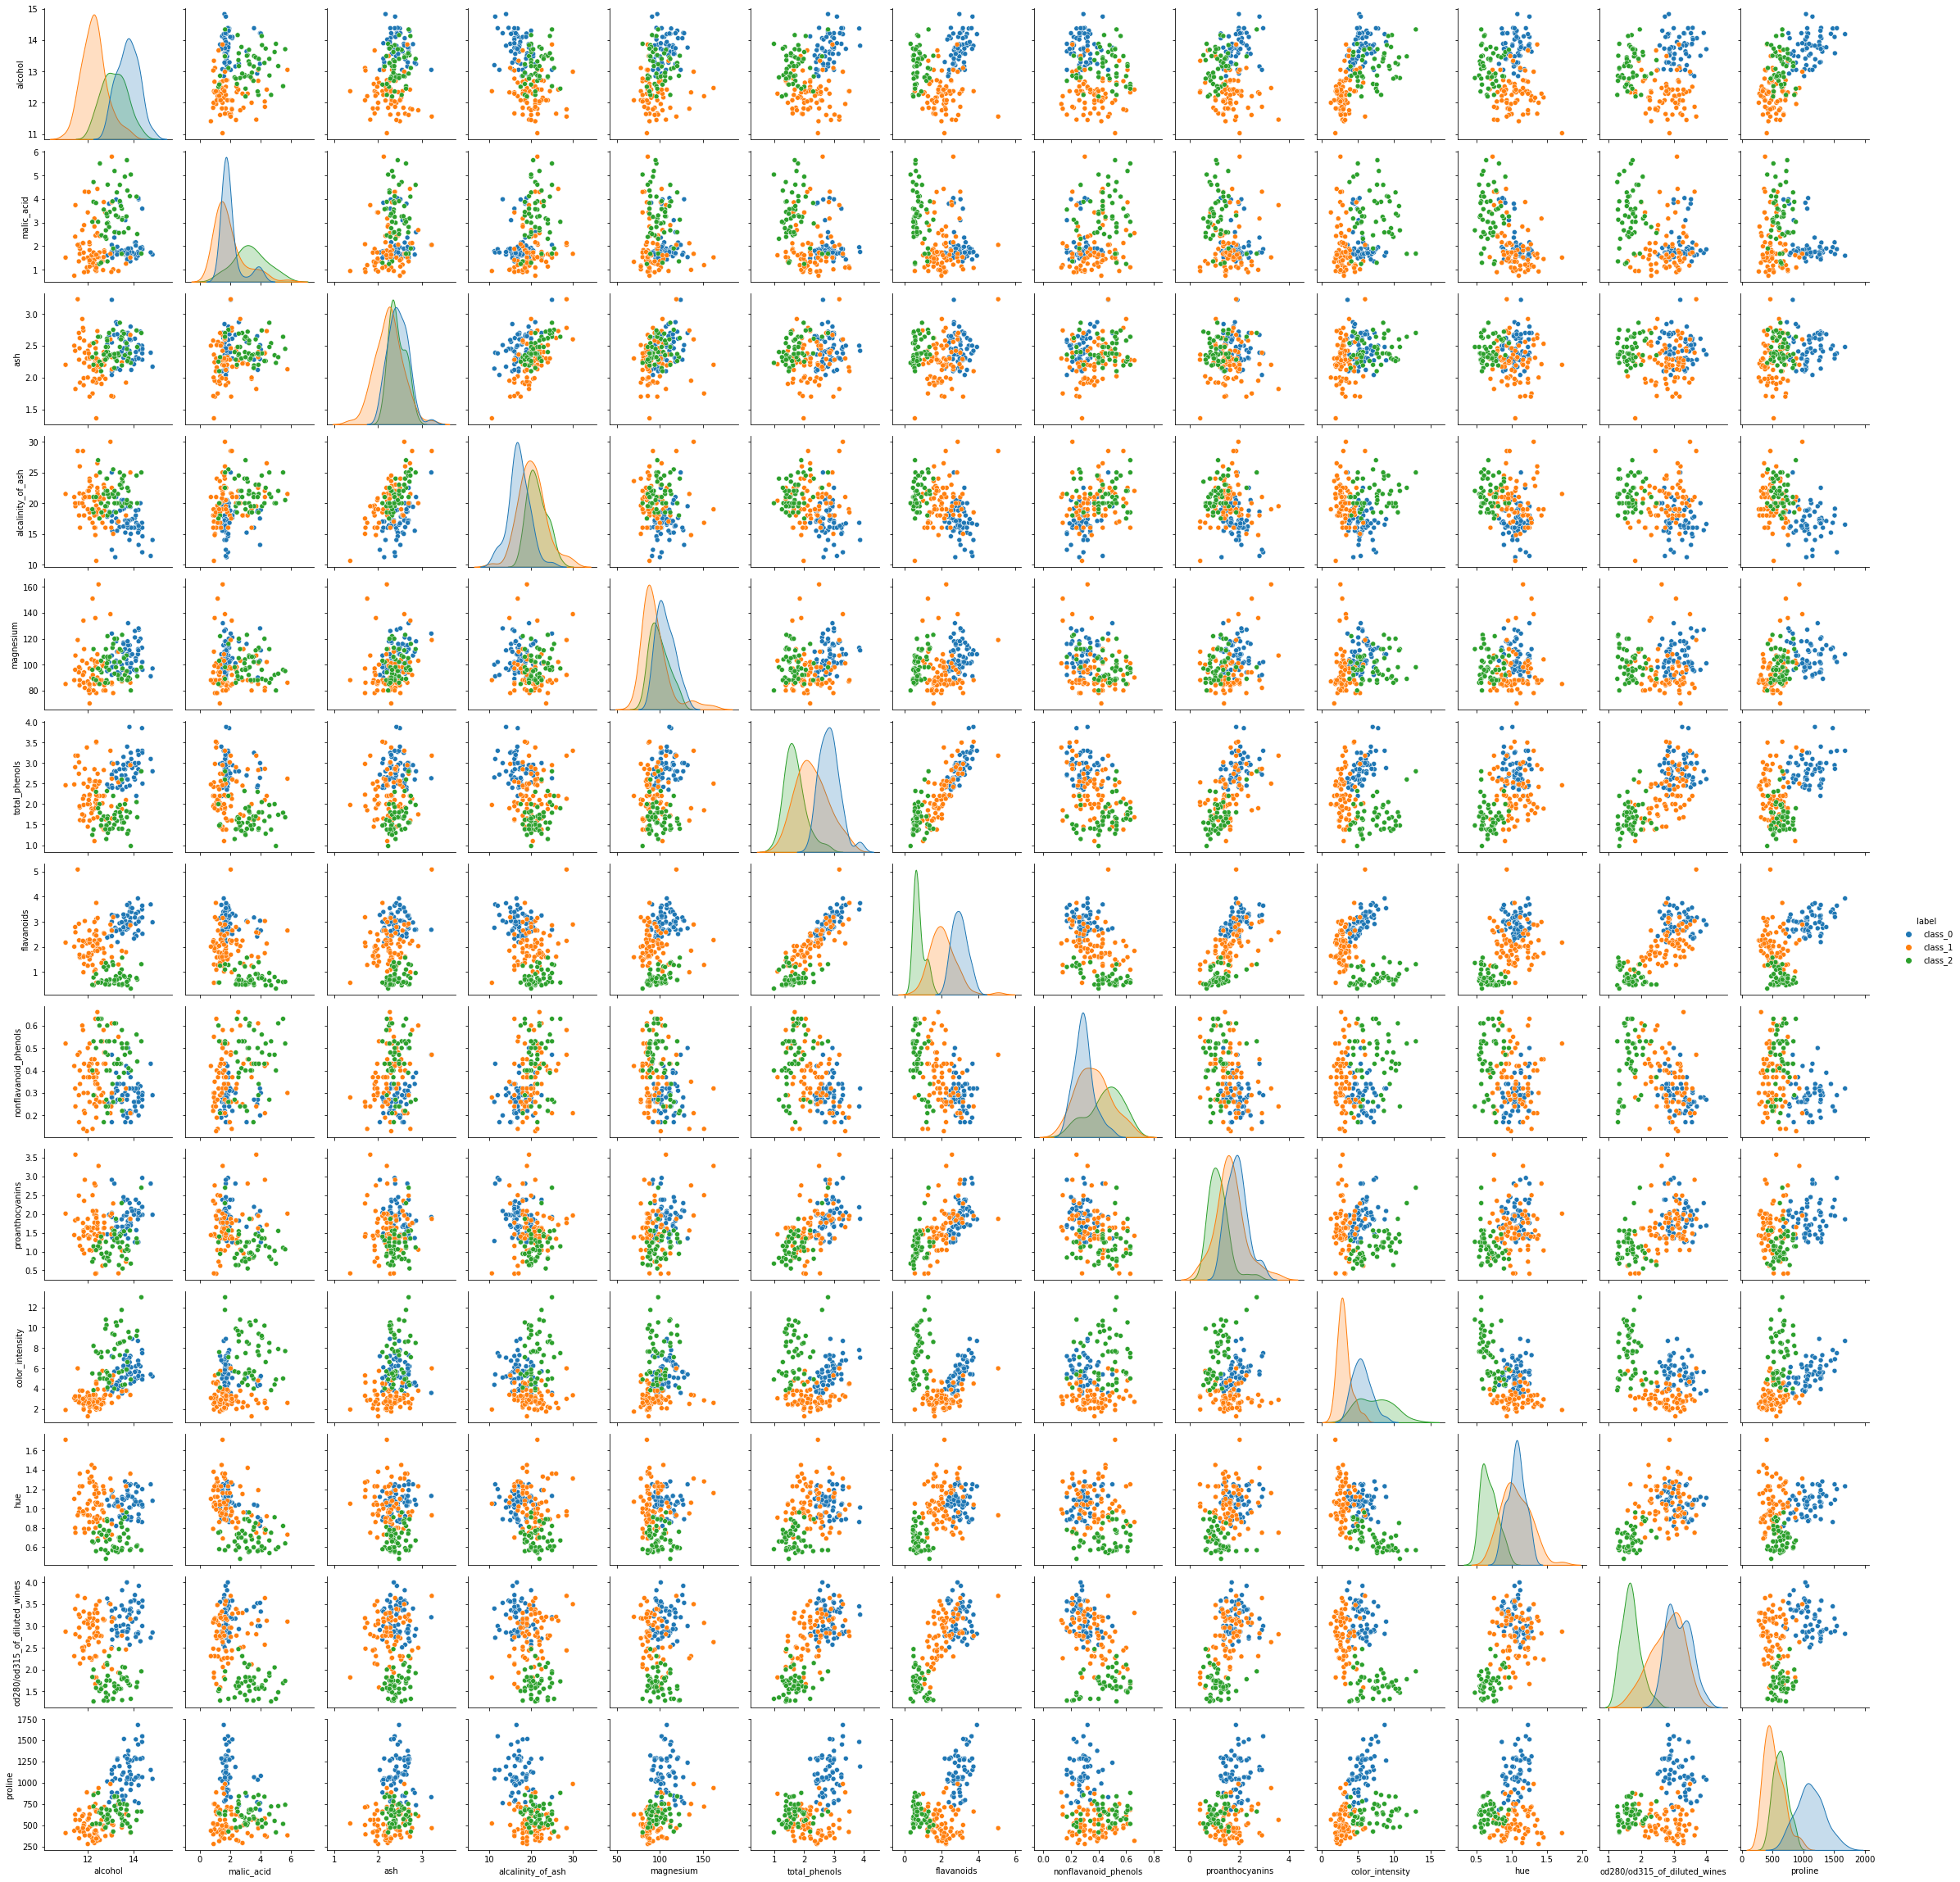

In [29]:
sns.pairplot(winedf, hue = 'label')

> Ao analisar as distribuições e relações dos dados, é possível perceber certa confusão entre as três classes de vinho que estão presentes no conjunto de dados. Mas, cabe notar que, com o uso de determinados atributos, vê-se uma clara divisão, como acontece em atributos como `hue` e `proline` ou mesmo com `proline` e `OD280/OD315 of diluted wines`.

### Teste 1 - Definição do grid de neurônios

Neste primeiro teste, seguindo os passos apresentados no primeiro experimento, será realizado o processo de definição do grid de neurônios da camada de saída da rede SOM. Diferente da abordagem apresentada anteriormente, neste, será feita a utilização da heurística de definição citada por [Shalaginov & Franke, 2015](https://link.springer.com/chapter/10.1007/978-3-319-19222-2_46). Nesta, a definição do grid é feita utilizando a seguinte equação

$ 5 \sqrt{N} $, 

onde:

$N$ representa a quantidade de amostras.

**Funções auxiliares**

In [30]:
def test1_plot_multi_som_maps(som_model: 'minisom.MiniSom', data: 'sklearn.utils.Bunch', **kwargs) -> None:
    """Função para visualizar U-Matrix, hitmap e heatmap do teste 1 do experimento 2
    
    Args:
        som_model (minisom.MiniSom): Instância MiniSom
        
        data (sklearn.utils.Bunch): Bunch de dados carregados do sklearn
    Returns:
        None
    """ 
    
    def plot_heat_map_som(som_model, data, **kwargs):
        """Função para visualizar U-Matrix, hitmap e heatmap

        Args:
            som_model (minisom.MiniSom): Instância MiniSom

            data (sklearn.utils.Bunch): Bunch de dados carregados do sklearn
        Returns:
            None
        """      
        # get grid shape
        grid_shape = som_model.get_weights().shape[0:2]

        plt.figure(**kwargs)
        heatmap(som_model, data.feature_names, (4, 4), cmap='Reds')
        plt.suptitle('heatmap')
        
        plt.show()
    
    plt.figure(**kwargs)
    
    plt.subplot(2, 2, 1)
    umatrix(som_model, cmap='Reds')
    plt.title('U-Matrix')
    
    plt.subplot(2, 2, 2)
    hitmap(som_model, data.data, cmap='Reds')
    plt.title('hitmap')
    
    plt.show()
    plot_heat_map_som(som_model, data, **kwargs)

Com isto, o mapa é criada abaixo seguindo a definição da heurística.

> Neste teste, a inicialização dos pesos será feito pelo método de seleção aleatória de amostras citado anteriormente. Em testes subsequentes, o impacto de tal inicialização é tratado.


In [31]:
# sqrt(N)
np.sqrt(wine.data.shape[0])

13.341664064126334

In [32]:
# 13x13x (13) -> representa a quantidade de atributos
som13x13 = MiniSom(13, 13, 13, random_seed = RANDOM_STATE)

som13x13.random_weights_init(wine.data)
train_error = manual_random_training(som13x13, wine.data, 1000)

print_error(som13x13, wine.data)

/opt/conda/lib/python3.7/site-packages/minisom.py:486: RuntimeWarning: invalid value encountered in sqrt


quantization_error: 8.436442207854396
topographic_error: 0.47191011235955055


Visualizando a evolução dos erros topográficos e de quantização

In [33]:
train_error = train_error.melt(ignore_index = False)

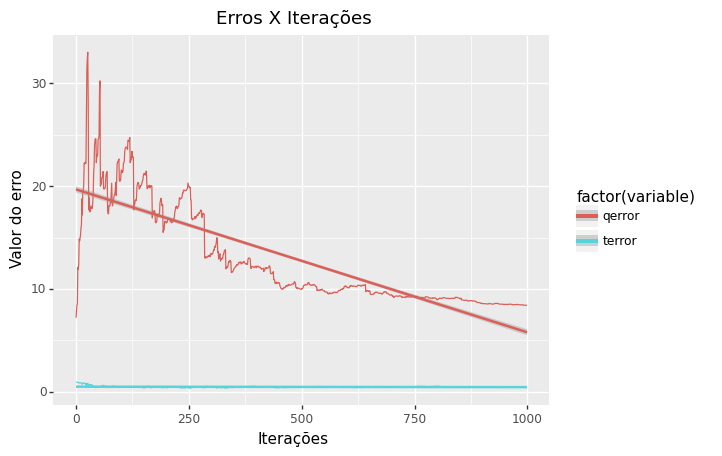

<ggplot: (8772235863317)>

In [34]:
(
    ggplot(train_error, aes(x = "train_error.index", y = "value", color='factor(variable)'))
        + geom_line()
        + stat_smooth(method='lm')
        + xlab("Iterações")
        + ylab("Valor do erro")
        + ggtitle("Erros X Iterações")
)

Por conta do tamanho do mapa gerado, o erro de quantização teve seu início com valores elevados, por outro lado, os erros relacionados a topografia tiveram variações bem menores. Para entender tal comportamento, a visualização dos mapas é feita abaixo.

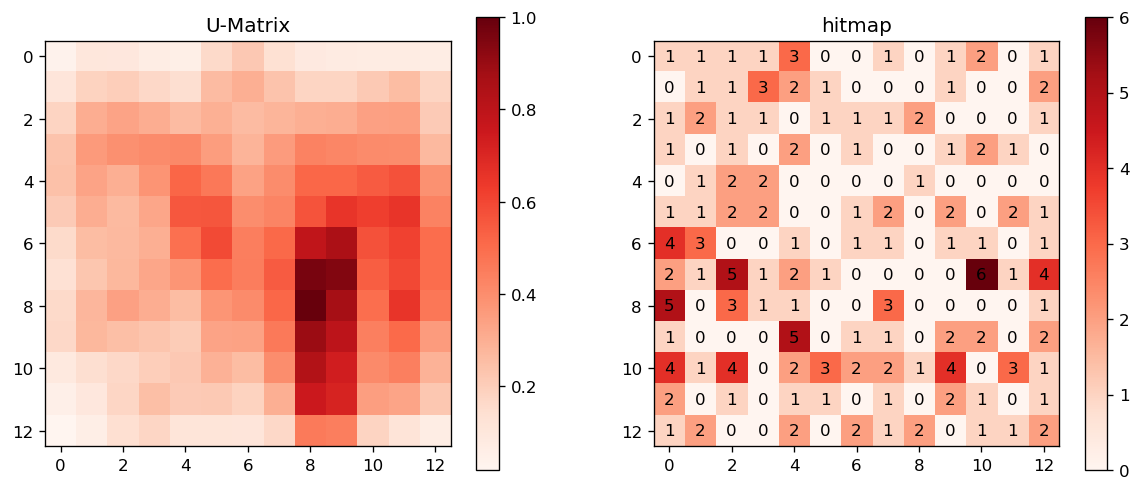

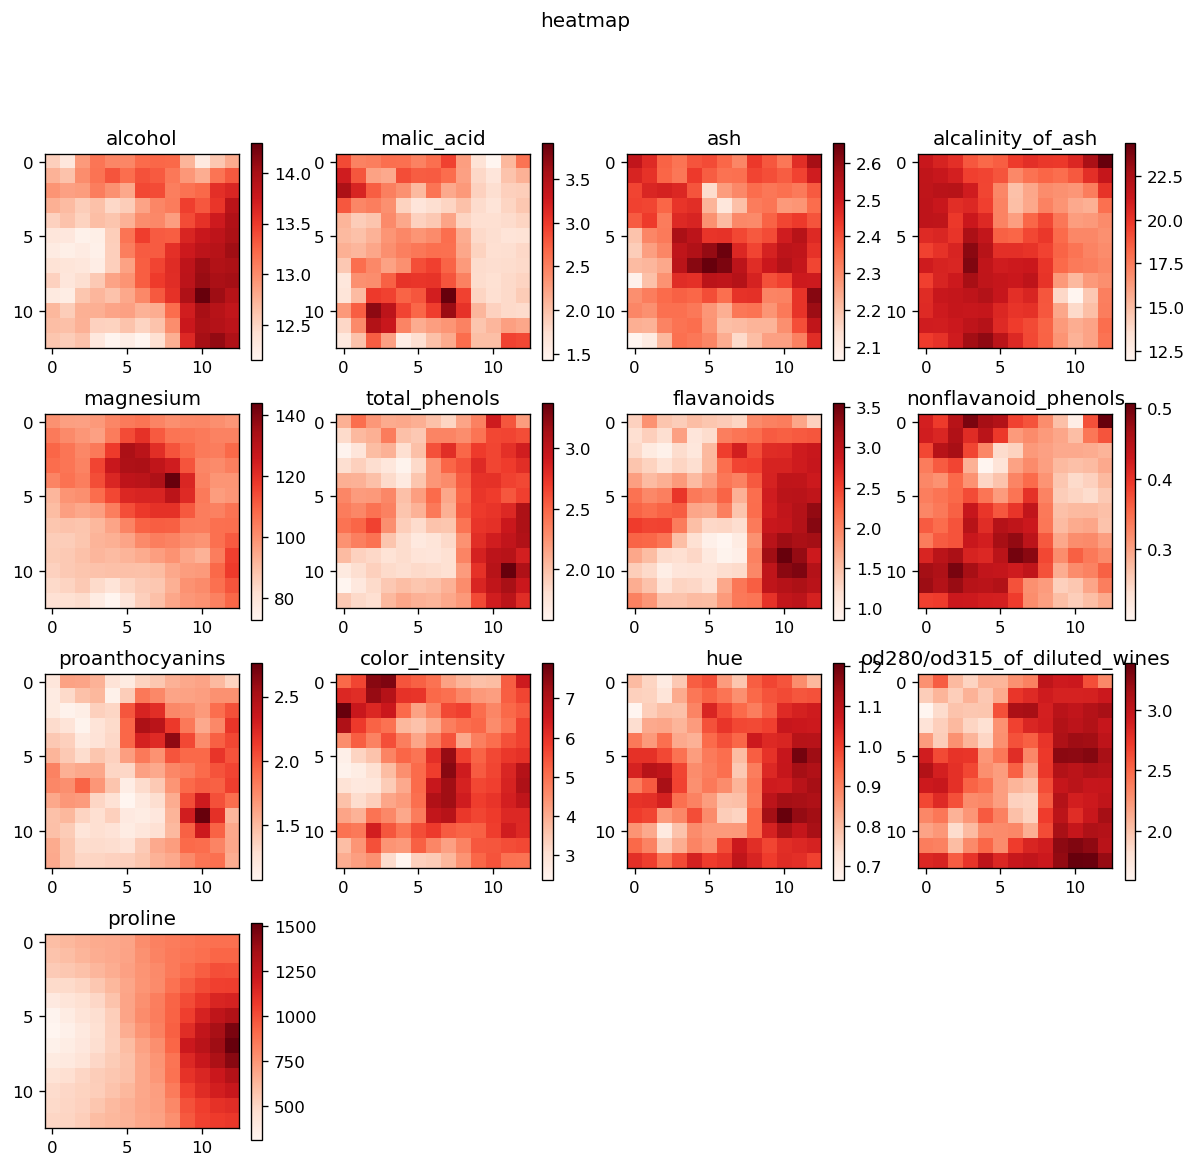

In [35]:
test1_plot_multi_som_maps(som13x13, wine, dpi=120, figsize=(12, 11))

Pela análise da matriz de distâncias é possível perceber certas tendências de grupos e áreas de transição. Como neste conjunto de dados está disponível os rótulos de cada classe, estes serão utilizados para que as representações possam ser melhor entendidas.

Text(0.5, 1.0, 'SOM (13x13) \n lr = 0.5, alpha=1')

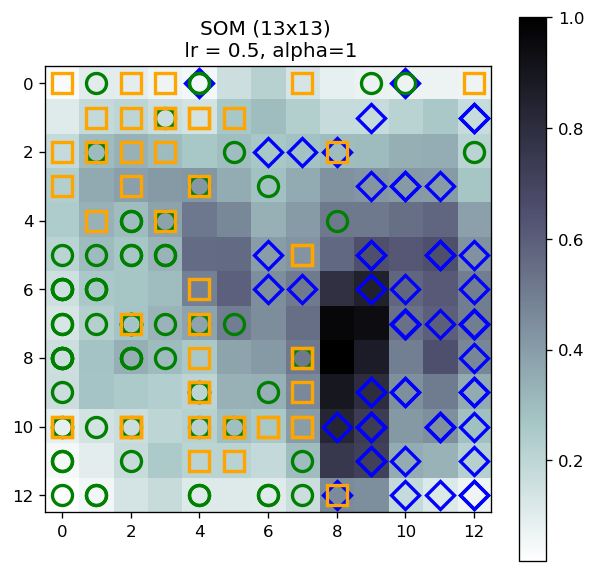

In [36]:
plt.figure(dpi = 120, figsize = (6, 6))

colors = ['green', 'orange', 'blue']
markers = ['o', 's', 'D']

umatrix_labeled(som13x13, wine.data, wine.target, colors, markers, cmap = 'bone_r')
plt.title('SOM (13x13) \n lr = 0.5, alpha=1')

Com a visualização deste mapa, é possível perceber que a granularidade de informações obtidas através do uso da heurística é grande. Existem diversos neurônios que são especializados em apenas uma única amostra, isso pode representar a adaptação a outlayers presentes no conjunto de dados, ou mesmo a elementos específicos presentes nos comportamentos das classes.

Analisando a disposição dos elementos junto ao `heatmap` é possível perceber os comportamentos citados anteriormente. Por exemplo, para o caso dos neurônios no canto superior direito do grid (Representados respectivamente pelas cores laranja, azul e verde), representam elementos que possuem valores altos de `Alcalinidade das cinzas`. Outro comportamento interessante é o apresentado pelas amostras em azul, dispostos de maneira predominante na parte inferior direita do mapa. Ao olhar a mesma região no `heatmap` é possível notar que os atributos de `alcohol`, `proline`, `flavonoid`, `non-flavonoid` e `OD280` tem características bem acentuadas, o que pode estar representando as características mais relevantes dessa classe.

### Teste 2 - Inicialização dos neurônios

Em todos os testes apresentados até aqui, fez-se o processo de inicialização dos pesos baseado nas amostras disponíveis no conjunto de dados, o que como visto durante as aulas, pode indicar um trabalho dobrado para a convergência da rede. Na biblioteca MiniSom o método de inicialização dos neurônios utilizando análise de principais componentes (PCA) está disponível.


In [37]:
som13x13_pca = MiniSom(13, 13, 13, random_seed = RANDOM_STATE)

som13x13_pca.pca_weights_init(wine.data)
train_error_pca = manual_random_training(som13x13_pca, wine.data, 1000)

print_error(som13x13_pca, wine.data)

quantization_error: 12.12475463073504
topographic_error: 0.3595505617977528


Façamos a visualização da variação dos erros

In [38]:
train_error_pca = train_error_pca.melt(ignore_index = False)

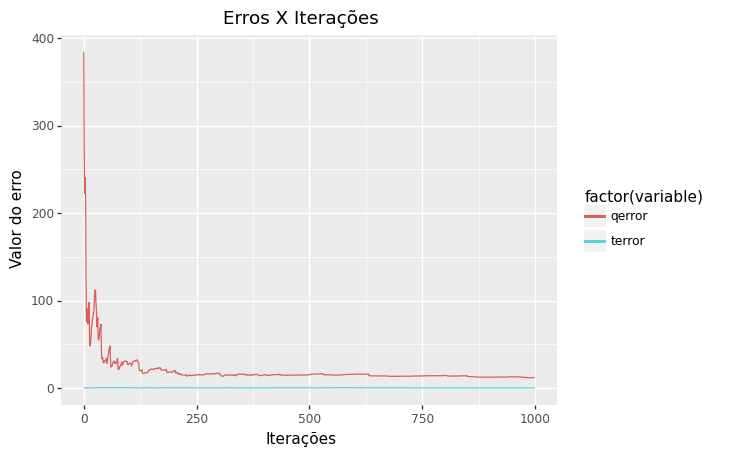

<ggplot: (8772226655301)>

In [39]:
(
    ggplot(train_error_pca, aes(x = "train_error_pca.index", y = "value", color='factor(variable)'))
        + geom_line()
        + xlab("Iterações")
        + ylab("Valor do erro")
        + ggtitle("Erros X Iterações")
)

Façamos a visualização da U-Matrix com os rótulos dos dados

Text(0.5, 1.0, 'SOM (13x13) with PCA \n lr = 0.5, alpha=1')

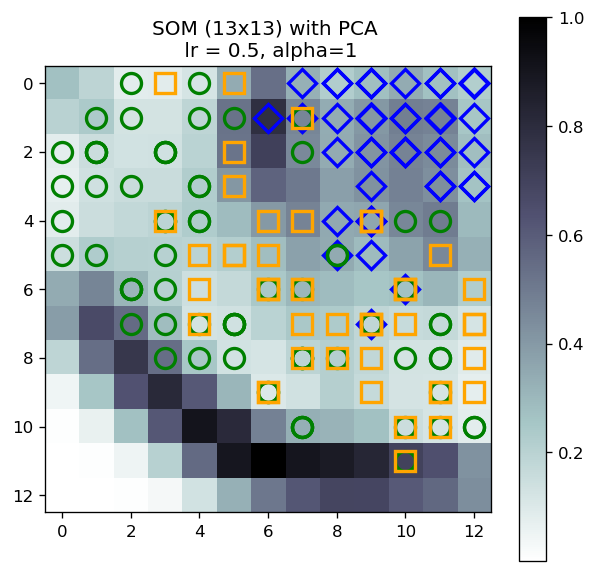

In [40]:
plt.figure(dpi = 120, figsize = (6, 6))

colors = ['green', 'orange', 'blue']
markers = ['o', 's', 'D']

umatrix_labeled(som13x13_pca, wine.data, wine.target, colors, markers, cmap = 'bone_r')
plt.title('SOM (13x13) with PCA \n lr = 0.5, alpha=1')

Partindo da análise dos principais componentes, visualmente, as representações geraram um comportamento menos esparso. Como este processo pode estar sendo influênciado pela escala dos dados, abaixo é feito o mesmo teste considerando os dados com padronização estatística aplicada.

> O processo de padronização estatística é feito com o auxílio da biblioteca `scikit-learn`.


In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
wine_scaled = scaler.fit_transform(wine.data)

In [42]:
som13x13_pca_scaled = MiniSom(13, 13, 13, random_seed = RANDOM_STATE)

som13x13_pca_scaled.pca_weights_init(wine_scaled)
train_error_pca_scaled = manual_random_training(som13x13_pca_scaled, wine_scaled, 1000)

print_error(som13x13_pca_scaled, wine_scaled)

quantization_error: 1.2421056641686752
topographic_error: 0.06741573033707865


In [43]:
train_error_pca_scaled = train_error_pca_scaled.melt(ignore_index = False)

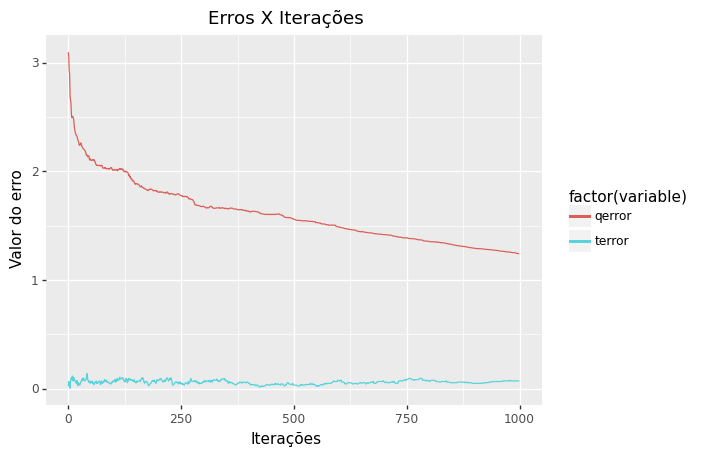

<ggplot: (8772226361217)>

In [44]:
(
    ggplot(train_error_pca_scaled, aes(x = "train_error_pca_scaled.index", y = "value", color='factor(variable)'))
        + geom_line()
        + xlab("Iterações")
        + ylab("Valor do erro")
        + ggtitle("Erros X Iterações")
)

Text(0.5, 1.0, 'SOM (13x13) with PCA init \n lr = 0.5, alpha=1, std = 1')

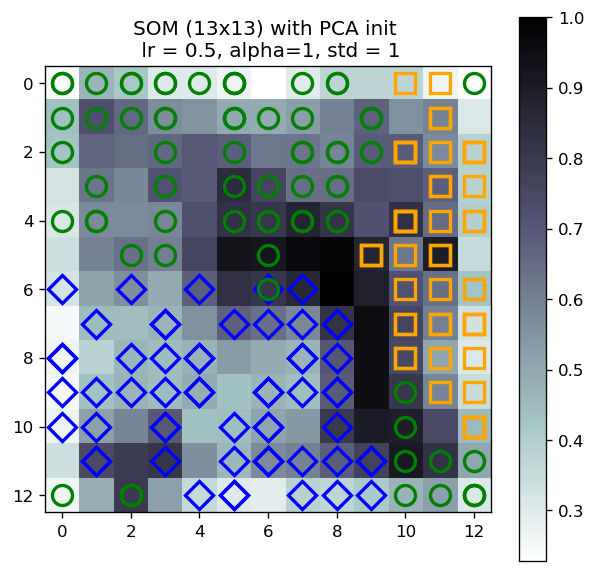

In [45]:
plt.figure(dpi = 120, figsize = (6, 6))

colors = ['green', 'orange', 'blue']
markers = ['o', 's', 'D']

umatrix_labeled(som13x13_pca_scaled, wine_scaled, wine.target, colors, markers, cmap = 'bone_r')
plt.title('SOM (13x13) with PCA init \n lr = 0.5, alpha=1, std = 1')

Ao normalizar os dados e aplicar PCA na inicialização dos pesos, é possível perceber um comportamento mais controlado com relação as misturas que eram anteriormente apresentadas, o que reflete também no erro de quantização, que nos testes anteriores estava elevado. Outro detalhe interessante são os elementos que possuem neurônios especializados, como acontece com os elementos em verde no canto inferior esquerdo. 

A padronização é possívelmente o processo que causa a melhora, já que isto evita problemas com as representações de elementos com valores em escalas distintas. Para confirmar tal afirmação, o treinamento da rede é feito novamente, com inicialização aleatória.


quantization_error: 1.2358241977890412
topographic_error: 0.033707865168539325


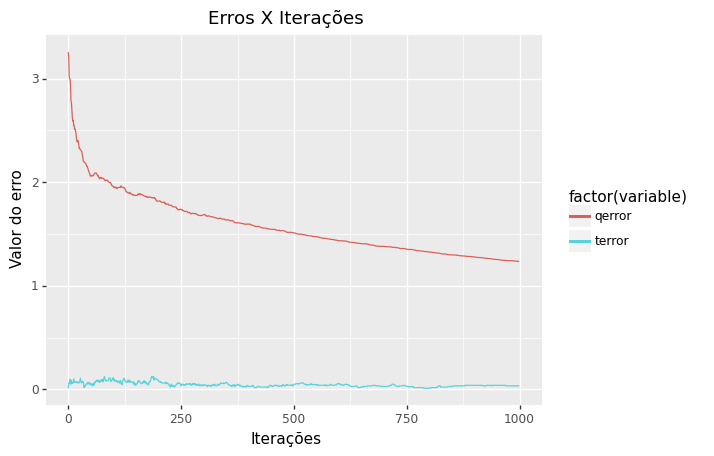

<ggplot: (8772227006481)>

In [46]:
som13x13_random_scaled = MiniSom(13, 13, 13, random_seed = RANDOM_STATE)

som13x13_random_scaled.pca_weights_init(wine_scaled)
train_error_random_scaled = manual_random_training(som13x13_random_scaled, wine_scaled, 1000)

print_error(som13x13_random_scaled, wine_scaled)
train_error_random_scaled = train_error_random_scaled.melt(ignore_index = False)

(
    ggplot(train_error_random_scaled, aes(x = "train_error_random_scaled.index", y = "value", color='factor(variable)'))
        + geom_line()
        + xlab("Iterações")
        + ylab("Valor do erro")
        + ggtitle("Erros X Iterações")
)

Text(0.5, 1.0, 'SOM (13x13) with Random init \n lr = 0.5, alpha=1, std = 1')

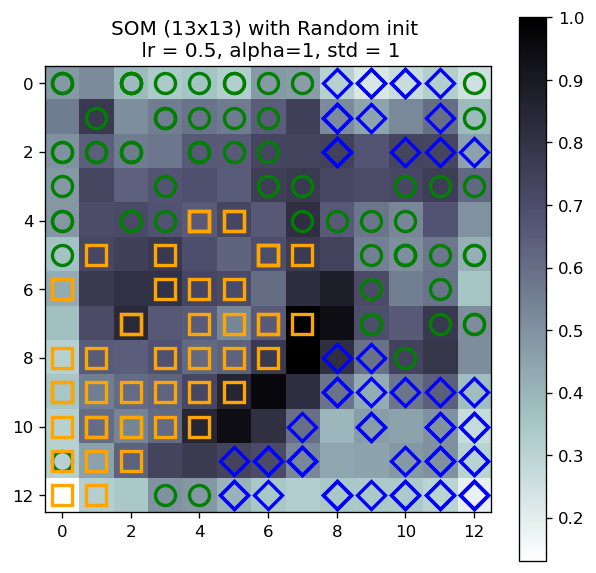

In [47]:
plt.figure(dpi = 120, figsize = (6, 6))

colors = ['green', 'orange', 'blue']
markers = ['o', 's', 'D']

umatrix_labeled(som13x13_random_scaled, wine_scaled, wine.target, colors, markers, cmap = 'bone_r')
plt.title('SOM (13x13) with Random init \n lr = 0.5, alpha=1, std = 1')

Como é possível perceber, a afirmação é valida, assim como apresentado em aula, onde foi dito que tal processo de normalização/padronização **deve** ser realizado quando o trabalho com o SOM está sendo considerado. Assim, de maneira geral, para a melhoria nos resultados apresentados anteriormente, este processo poderia ser realizado. A normalização foi empregada nesta parte para que, o comportamento da rede frente a várias mudanças em sua estrutura, mas sem mudanças nos dados pudessem ser percebidos.

> Note que neste teste, a inicialização PCA acabou gerando uma representação onde elementos da classe azul se mantiveram próximas com a quantidade de iterações definida, enquanto os valores aleatórios causaram uma pequena confusão.


### Experimento 3 - Satellite Image Time Series

Como forma de testar um tipo de dado diferente dos aplicados até aqui, neste experimento será feita a utilização de *Satellite Image Time Series* (SITS). Para isto, foram extraídos as séries temporais classificadas que estão presente no pacote [e-sensing/inSitu](https://github.com/e-sensing/inSitu). Para isso, fez-se a extração dos dados do pacote e em seguida sua conversão para um formato agradável ao Python.

> O pacote inSitu foi criado dentro do contexto do projeto e-sensing, e todos os dados presentes no pacote são livres, com licença `GNU General Public License v2.0` e podem ser consumidos em diferentes projetos e trabalhos.

Os dados extraídos para este experimento são séries temporais de dados MOD13Q1 do sensor MODIS/Terra. Além disso cabe citar que nos testes apenas o índice de vegetação normalizado (NDVI) será utilizado, porém, no conjunto de dados dados estão disponíveis as demais bandas espectrais e outros índices com o Enhanced Vegetation Index (EVI).

No total estão presentes 1892 séries, cada uma contendo 23 valores temporais que serão utilizados como os atributos de entrada para o SOM.

> Cabe informar que as visualizações apresentadas nesta seção, quando realizadas em múltiplas execuções, podem variar nas **cores**, mas por conta da seed definida, os resultados serão exatamente os mesmos.


**Funções auxiliares**

In [48]:
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec


def test1_grid_by_label(som_model, ts_data, ts_label, **kwargs):
    """Função para visualizar um grid com cores criadas com base nas classes já definidas
    
    Args:
        som_model (minisom.MiniSom): MiniSom Model
        
        ts_data (np.ndarray): n-dimensional array com as definições e os valores 
        das séries temporais  (Deve conter somente as séries em colunas)
        
        ts_label (np.ndarray): 1-dimensinal array com as classes de cada séries temporal
        
        kwargs (dict): Argumentos passados para a função legend
    Returns:
        None
        
    See:
        https://github.com/JustGlowing/minisom/blob/193fa578fa28974c2853548999dcd2bd034bede9/examples/BasicUsage.ipynb
    """

    colors = {
        i[1]:list(mcolors.TABLEAU_COLORS.values())[i[0]] for i in enumerate(set(ts_label))
    }

    n_neurons, m_neurons = som_model.get_weights().shape[0:2]
    grid_spec = gridspec.GridSpec(n_neurons, m_neurons, plt.gcf())

    patches_dict = []
    patches_labels = []

    # plot específico para o formato de dados do SITS
    labels_map = som_model.labels_map(ts_data, ts_label)
    for position in labels_map.keys():
        plt.subplot(grid_spec[n_neurons-1-position[1],
                             position[0]], aspect=1)
        
        patches, texts = plt.pie([float(v) for v in labels_map[position].values()], 
                                 colors = [colors[i] for i in labels_map[position].keys()],
                                 shadow = True)

        for i, p in zip(labels_map[position].keys(), patches):
            if i not in patches_labels:
                patches_dict.append(p)
                patches_labels.append(i)

    plt.legend(patches_dict, patches_labels, **kwargs)

Abaixo os dados são carregados.

In [49]:
from io import StringIO

# Carregando os dados de um link criado para hospedar as atividades de Neurocomputação
ts = pd.read_csv('https://fmenino-cap351.netlify.app/data/project_2/br_mt_1_8K_9classes_8bands.csv').set_index('Unnamed: 0')
ts['time_series'] = [pd.read_fwf(StringIO(ts.time_series.iloc[i])).dropna().set_index('Unnamed: 0') for i in range(ts.shape[0])]

Com os dados carregados, a disposição dos pontos é apresentada no mapa

In [50]:
import folium

fmap = folium.Map(location=(-12, -54), zoom_start=6)

for idx, row in ts.iterrows():
    folium.Marker((row.latitude, row.longitude), popup=row.label).add_to(fmap)
fmap

Agora, para tornar o uso das séries temporais mais simples no MiniSom é feito uma transformação nas séries temporais, de modo a gerar uma lista de séries.

In [51]:
ts_data = np.array([ts.time_series.iloc[i]['NDVI'].values for i in range(ts.shape[0])])

Normalizando as séries para melhorar os resultados de treinamento.

> Em testes realizados e seguindo a mesma lógica apresentada nas aulas e vista nos exemplos anteriores, ao não realizar a normalização, os neurônios acabaram não realizando boas representações das séries.

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ts_data = scaler.fit_transform(ts_data.T).T

### Teste 1 - Sigma

Para o primeiro teste com este conjunto de dados, será feita a variação do grau de influência do vencedor em seus vizinhos (sigma). Como citado anteriormente, este elemento, na implementação do MiniSom, é utilizado para o cálculo de uma área de ação através de um círculo de influência. Para estes testes será inicialmente realizado o uso de um grid 8x8.

> Como citado no primeiro experimento, o valor de sigma por padrão é 1, aqui, será feito a sua variação, começando com valores menores e aumentando.

> Neste teste será considerado o uso da definição dos pesos por PCA

**Sigma = 0.3**

In [53]:
som8x8_sigma03 = MiniSom(8, 8, ts_data.shape[1], sigma=.3, random_seed=RANDOM_STATE)

In [54]:
som8x8_sigma03.pca_weights_init(ts_data)

# No treinamento batch, a atualização ocorre
# para cada elemento, e estes são apresentados de maneira
# sequencial (Retirado da documentação do código fonte)
som8x8_sigma03.train_batch(ts_data, 50000)

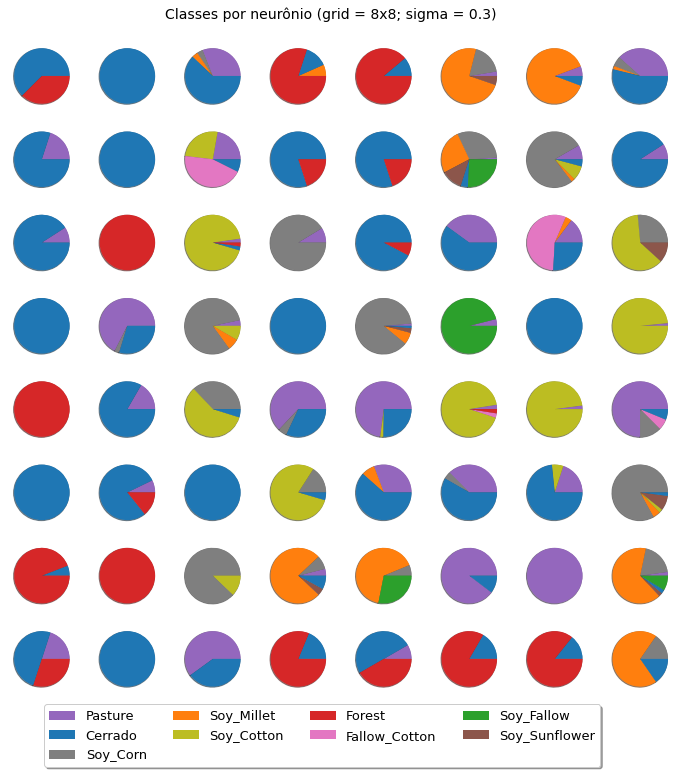

In [55]:
fig = plt.figure(figsize=(12, 12))

plt.suptitle('Classes por neurônio (grid = 8x8; sigma = 0.3)', y = 0.92, fontsize=14)
test1_grid_by_label(som8x8_sigma03, ts_data, ts.label, shadow=True, bbox_to_anchor=(0.82, 0.12), bbox_transform=fig.transFigure, frameon=True, ncol = 4, fontsize=13)

**Sigma = 0.5**

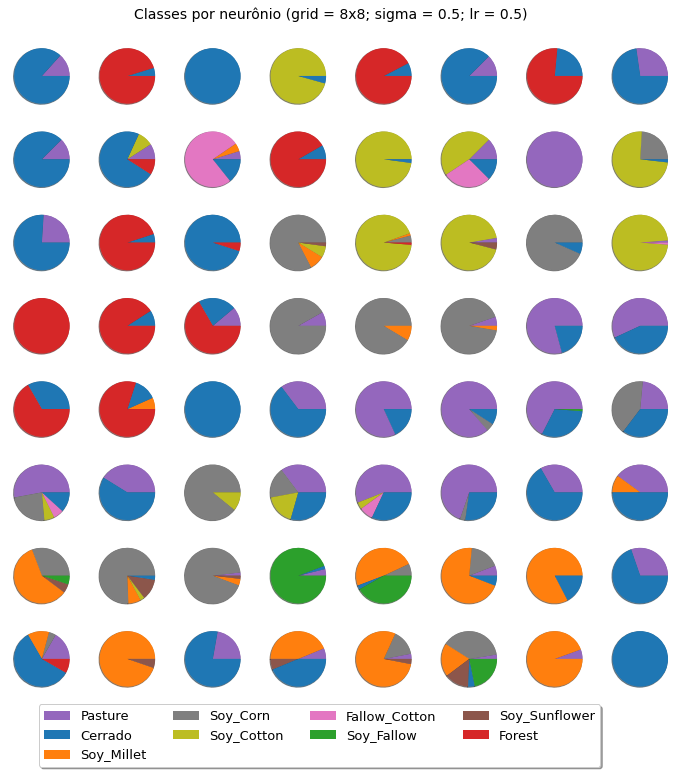

In [56]:
som8x8_sigma05 = MiniSom(8, 8, ts_data.shape[1], sigma=.5, random_seed=RANDOM_STATE)
som8x8_sigma05.pca_weights_init(ts_data)

som8x8_sigma05.train_batch(ts_data, 50000)
fig = plt.figure(figsize=(12, 12))

plt.suptitle('Classes por neurônio (grid = 8x8; sigma = 0.5; lr = 0.5)', y = 0.92, fontsize=14)
test1_grid_by_label(som8x8_sigma05, ts_data, ts.label, shadow=True, bbox_to_anchor=(0.82, 0.12), bbox_transform=fig.transFigure, frameon=True, ncol = 4, fontsize=13)

**Sigma = 0.7**

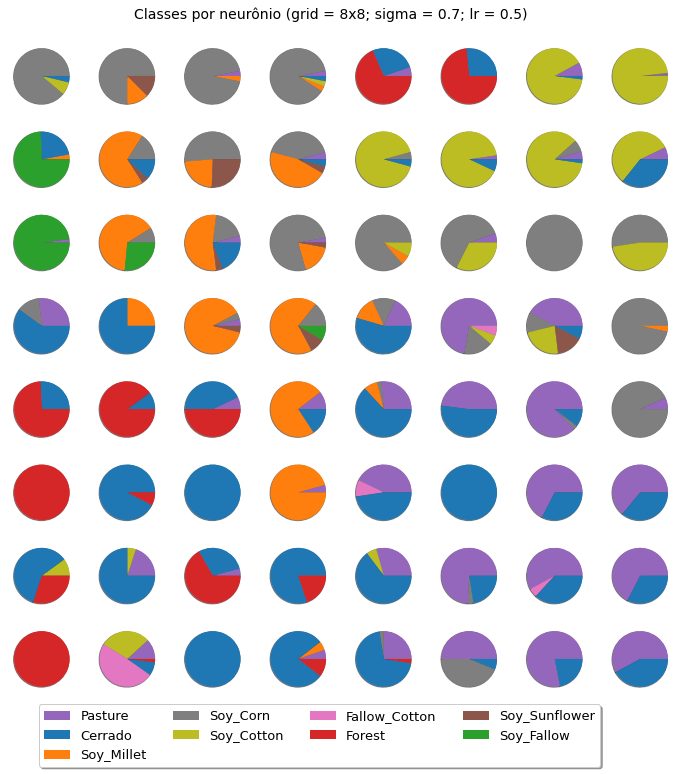

In [57]:
som8x8_sigma07 = MiniSom(8, 8, ts_data.shape[1], sigma=.7, random_seed=RANDOM_STATE)
som8x8_sigma07.pca_weights_init(ts_data)

som8x8_sigma07.train_batch(ts_data, 50000)
fig = plt.figure(figsize=(12, 12))

plt.suptitle('Classes por neurônio (grid = 8x8; sigma = 0.7; lr = 0.5)', y = 0.92, fontsize=14)
test1_grid_by_label(som8x8_sigma07, ts_data, ts.label, shadow=True, bbox_to_anchor=(0.82, 0.12), bbox_transform=fig.transFigure, frameon=True, ncol = 4, fontsize=13)

**Sigma = 1 (Parâmetro padrão da função)**

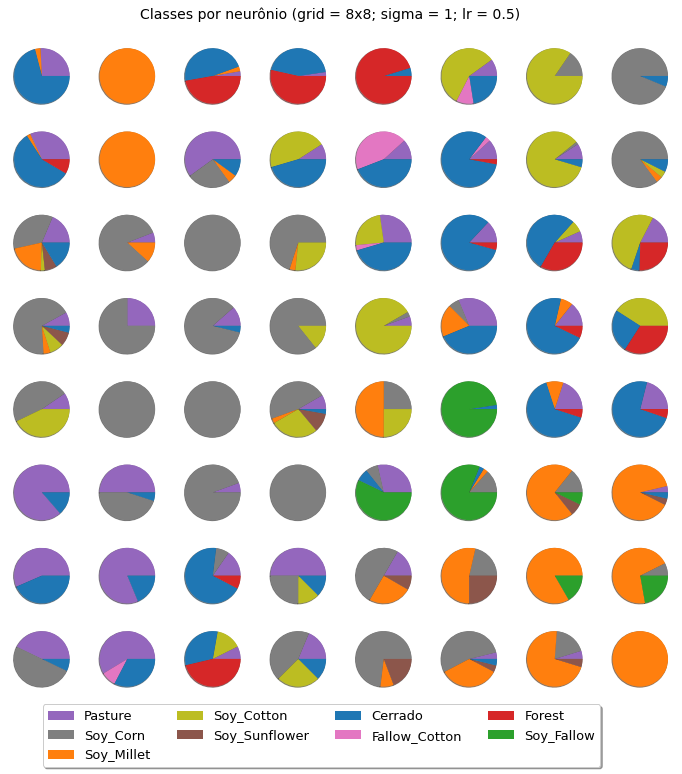

In [58]:
som8x8_sigma1 = MiniSom(8, 8, ts_data.shape[1], sigma=1, random_seed=RANDOM_STATE)
som8x8_sigma1.pca_weights_init(ts_data)

som8x8_sigma1.train_batch(ts_data, 50000)
fig = plt.figure(figsize=(12, 12))

plt.suptitle('Classes por neurônio (grid = 8x8; sigma = 1; lr = 0.5)', y = 0.92, fontsize=14)
test1_grid_by_label(som8x8_sigma1, ts_data, ts.label, shadow=True, bbox_to_anchor=(0.82, 0.12), bbox_transform=fig.transFigure, frameon=True, ncol = 4, fontsize=13)

**Sigma = 1.5**

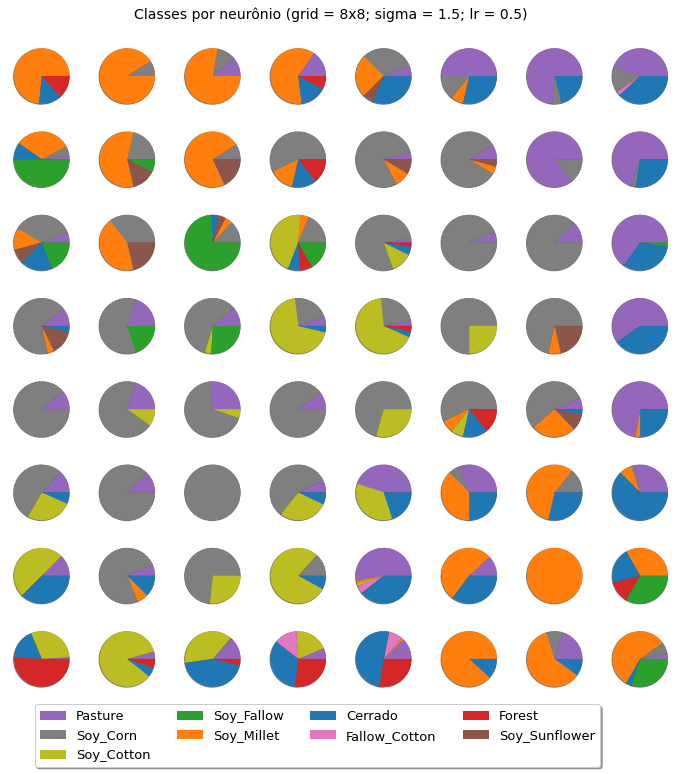

In [59]:
som8x8_sigma15 = MiniSom(8, 8, ts_data.shape[1], sigma=1.5, random_seed=RANDOM_STATE)
som8x8_sigma15.pca_weights_init(ts_data)

som8x8_sigma15.train_batch(ts_data, 50000)
fig = plt.figure(figsize=(12, 12))

plt.suptitle('Classes por neurônio (grid = 8x8; sigma = 1.5; lr = 0.5)', y = 0.92, fontsize=14)
test1_grid_by_label(som8x8_sigma15, ts_data, ts.label, shadow=True, bbox_to_anchor=(0.82, 0.12), bbox_transform=fig.transFigure, frameon=True, ncol = 4, fontsize=13)

Com os comportamentos apresentados é possível perceber que os baixos valores de sigma acabaram gerando um comportamento mais confuso, onde dentro de um único neurônio diversas formas estavam sendo representadas.

Ao analisar estes *micro-clusters* cabe uma questão, há classes que tem uma certa similaridade, neste ponto, cabe ao especialista determinar se tais elementos podem ser representados juntos, formando um nível de legenda de classes mais alto, ou um nível mais baixo, onde as particularidades devem separar cada um desses elementos. 

Outro ponto que precisa ser considerado é o relacionado aos locais onde tais elementos foram coletados. Mesmo pertencendo a uma mesma classe pode ser que eles sejam diferentes exatamente por terem sido gerados em áreas diferentes. Aqui, da mesma forma como apresentado anteriormente e citado durante as aulas pelo professor, é necessário que o especialista faça a avaliação de tais elementos e os alinhe com seus objetivos.


### Teste 2 - Variação do grid

No primeiro teste deste experimento foi utilizado um grid 8x8, porém, como forma de explorar se as classes acabam sofrendo divisões em suas representações, neste teste será feito a variação do grid, de modo a verificar os comportamentos gerados.

> Neste teste o sigma padrão será utilizado

> Algumas funções utilizadas neste teste foram geradas no teste anterior


**Funções auxiliares**

In [60]:
def test2_experiment3_plot_multi_som_maps(som_model: 'minisom.MiniSom', data: np.ndarray, **kwargs) -> None:
    """Função para visualizar hitmap e heatmap do teste 2 do experimento 3
    
    Args:
        som_model (minisom.MiniSom): Instância MiniSom
        
        data (np.ndarray): n-dimensional array 
        
    Returns:
        None
    """ 
    
    plt.figure(**kwargs)
    
    plt.subplot(2, 2, 1)
    hitmap(som_model, data, transpose=True, cmap='Reds')
    plt.title('hitmap')
        
    plt.subplot(2, 2, 2)
    umatrix(som_model, transpose=True, cmap='Reds')
    plt.title('U-Matrix')
    

def test1_tsmmm(som_model, ts_data, ts_label):
    """Função para plotar os valores de mínimo, máximo e média de cada neurônio
    
    Args:
        som_model (minisom.MiniSom): MiniSom Model
        
        ts_data (np.ndarray): Series temporais
        
        grid_spec (tuple): Tupla com a quantidade de linhas e colunas no grid
        
    Returns:
        None
        
    See:
        https://github.com/JustGlowing/minisom/blob/master/examples/TimeSeries.ipynb
    """
    
    win_map = som_model.win_map(ts_data)
    labels_map = som_model.labels_map(ts_data, ts_label)
    n_neurons, m_neurons = som_model.get_weights().shape[0:2]
    
    grid_spec = gridspec.GridSpec(n_neurons, m_neurons, plt.gcf())
    for position in labels_map.keys():
        plt.subplot(grid_spec[n_neurons-1-position[1], position[0]])
        plt.plot(np.min(win_map[position], axis=0), color='gray', alpha=.5)
        plt.plot(np.mean(win_map[position], axis=0))
        plt.plot(np.max(win_map[position], axis=0), color='gray', alpha=.5)


**Grid 4x4**

Primeiro será feita a avaliação com um grid menor ao apresentado no exemplo anterior será utilizado.


quantization_error: 3.2985017227879325
topographic_error: 0.2087737843551797


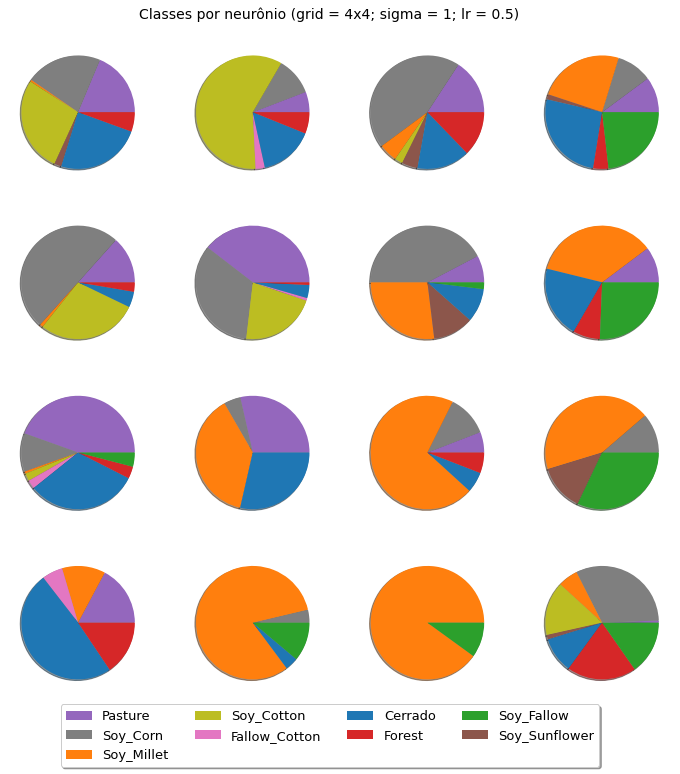

In [61]:
som4x4_test2 = MiniSom(4, 4, ts_data.shape[1], random_seed=RANDOM_STATE)
som4x4_test2.pca_weights_init(ts_data)

som4x4_test2.train_batch(ts_data, 50000)
fig = plt.figure(figsize=(12, 12))

plt.suptitle('Classes por neurônio (grid = 4x4; sigma = 1; lr = 0.5)', y = 0.92, fontsize=14)
test1_grid_by_label(som4x4_test2, ts_data, ts.label, shadow=True, bbox_to_anchor=(0.82, 0.12), bbox_transform=fig.transFigure, frameon=True, ncol = 4, fontsize=13)

print_error(som4x4_test2, ts_data)

**Grid 16x16**

quantization_error: 1.818617543955932
topographic_error: 0.15010570824524314


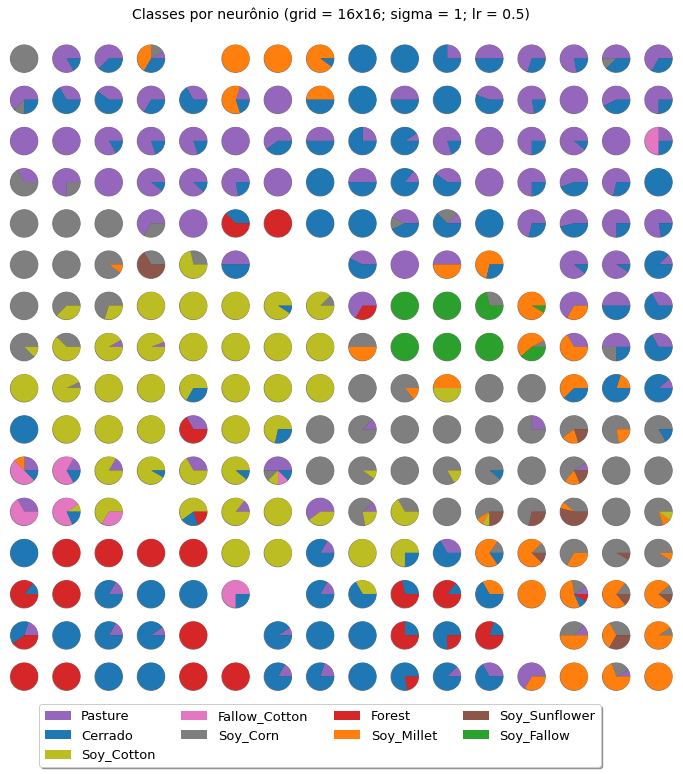

In [62]:
som16x16_test2 = MiniSom(16, 16, ts_data.shape[1], random_seed=RANDOM_STATE)
som16x16_test2.pca_weights_init(ts_data)

som16x16_test2.train_batch(ts_data, 50000)
fig = plt.figure(figsize=(12, 12))

plt.suptitle('Classes por neurônio (grid = 16x16; sigma = 1; lr = 0.5)', y = 0.92, fontsize=14)
test1_grid_by_label(som16x16_test2, ts_data, ts.label, shadow=True, bbox_to_anchor=(0.82, 0.12), bbox_transform=fig.transFigure, frameon=True, ncol = 4, fontsize=13)

print_error(som16x16_test2, ts_data)

Visualizando a U-Matrix e Hitmap de cada um dos mapas gerados

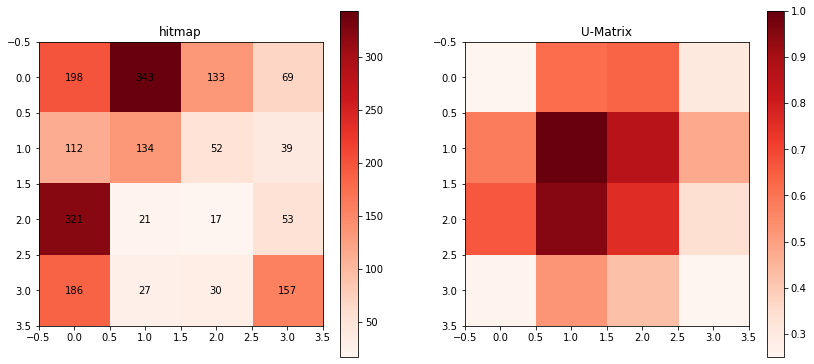

In [63]:
test2_experiment3_plot_multi_som_maps(som4x4_test2, ts_data, figsize = (14, 14))

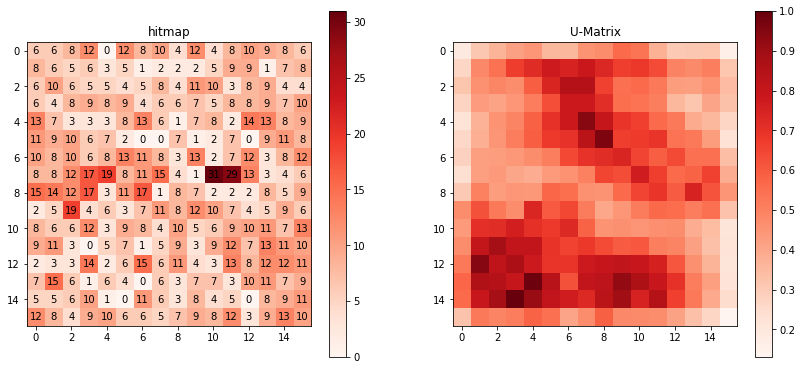

In [64]:
test2_experiment3_plot_multi_som_maps(som16x16_test2, ts_data, figsize = (14, 14))

Como pode ser visto, ao aumentar a quantidade de neurônios, houve uma maior especialização na representação de diversas classes. Quando considerado o hitmap do mapa 4x4, pode-se notar que este acabou gerando neurônios muito generalistas, que englobaram diversas classes. Já no mapa 16x16 teve-se um aumento da especialidade de cada neurônio a ponto de ter alguns que só foram ativados para um único padrão em uma classe.

> Cabe deixar claro nesta parte que, por vezes, os elementos únicos que destoam dos demais podem ser considerados *outlayers*, porém, neste contexto, onde há multiplas classes vindas de múltiplas regiões, pode ser que, amostras de classes iguais representam comportamentos ligeiramente diferentes. Neste ponto, cabe ao especialista fazer a avaliação.

Para finalizar, ambos os comportamentos serão visualizados considerando média, mínimos e máximos de cada neurônio, com isso é possível perceber o comportamento geral das amostras em cada um dos neurônios.


**Grid 4x4**

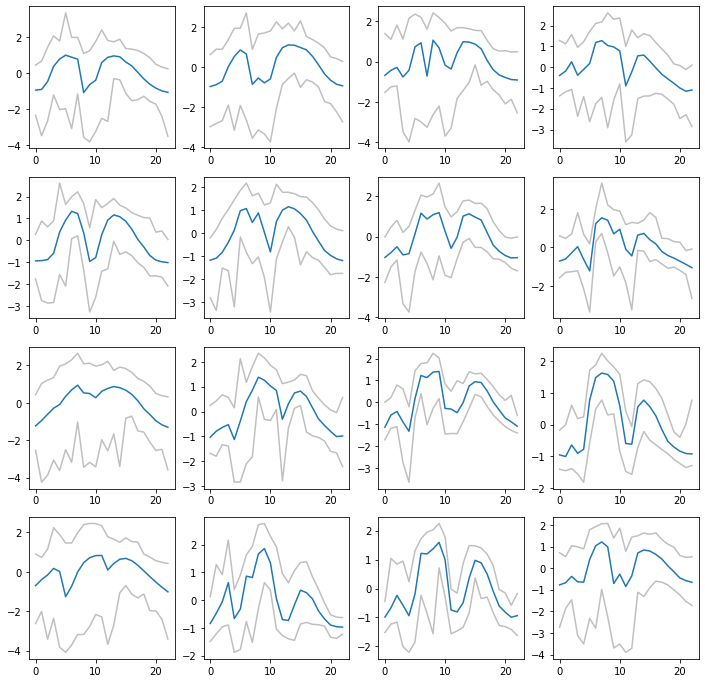

In [65]:
plt.figure(figsize=(12, 12))
test1_tsmmm(som4x4_test2, ts_data, ts.label)

**Grid 16x16**

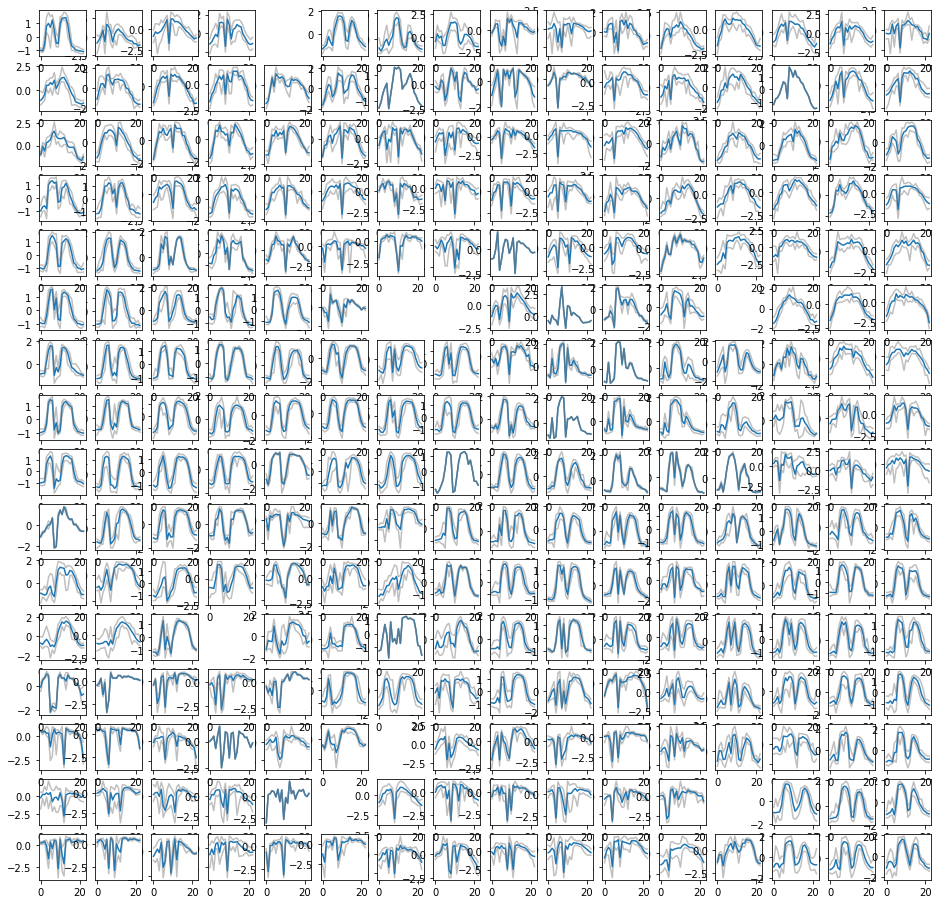

In [66]:
plt.figure(figsize=(16, 16))
test1_tsmmm(som16x16_test2, ts_data, ts.label)
plt.show()